In [1]:
# import
import talib
import pandas as pd
import numpy as np
from datetime import timedelta, datetime as dt
from pandas_datareader.data import get_data_yahoo

from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
from matplotlib.finance import candlestick_ochl
from matplotlib import pyplot as plt, gridspec

from pylab import rcParams

from datetime import datetime as dt, timedelta

style.use('ggplot')

/usr/local/lib/python3.4/dist-packages/matplotlib-2.0.0b4_3022.gdfd38f7-py3.4-linux-x86_64.egg/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# getting data
date2 = dt.now().date()
date1 = date2 - timedelta(days=90)        
df = get_data_yahoo('BAC', date1, date2)
df[-3:]

Open   High        Low      Close     Volume  Adj Close
Date                                                                    
2016-12-08  22.790001  23.24  22.690001  22.950001  182248500  22.950001
2016-12-09  22.950001  23.17  22.780001  23.090000  129135900  23.090000
2016-12-12  23.000000  23.25  22.540001  22.610001  136442200  22.610001

In [3]:
date1 = date2 - timedelta(days=300)        
df = get_data_yahoo('BAC', date1, date2)
len(df)  # days

209

In [4]:
rsi_values = talib.RSI(df['Close'].values, timeperiod=14)
df['RSI'] = pd.Series(rsi_values, index=df.index.values)
df[12:16][['RSI', 'Close']]

RSI  Close
Date                        
2016-03-04        NaN  13.54
2016-03-07        NaN  13.53
2016-03-08  57.142857  13.06
2016-03-09  58.172458  13.14

In [5]:
adx_values = talib.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
# NOTE: The ADX function has an unstable period.
df['ADX'] = pd.Series(adx_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'ADX']]

High        Low      Close        ADX
Date                                              
2016-12-08  23.24  22.690001  22.950001  56.340416
2016-12-09  23.17  22.780001  23.090000  57.664141
2016-12-12  23.25  22.540001  22.610001  58.171398

In [6]:
plus_di_values = talib.PLUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['PLUS_DI'] = pd.Series(plus_di_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'PLUS_DI']]

High        Low      Close    PLUS_DI
Date                                              
2016-12-08  23.24  22.690001  22.950001  53.917772
2016-12-09  23.17  22.780001  23.090000  51.006508
2016-12-12  23.25  22.540001  22.610001  46.123872

In [7]:
minus_di_values = talib.MINUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['MINUS_DI'] = pd.Series(minus_di_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'MINUS_DI']]

High        Low      Close  MINUS_DI
Date                                             
2016-12-08  23.24  22.690001  22.950001  7.747442
2016-12-09  23.17  22.780001  23.090000  7.329123
2016-12-12  23.25  22.540001  22.610001  9.863342

In [8]:
# Visual verification
def plot_data(title, df, instance=None, show=True):
        
    fig = plt.figure(figsize=(20, 25)) 
    gs = gridspec.GridSpec(4, 1, height_ratios=[3, 2, 1, 1]) 

    # Plot the candlestick    
    ax1 = plt.subplot(gs[0])
    candlestick_ochl(
        ax1, 
        ((date2num(r.Index), r.Open, r.Close, r.High, r.Low) for r in df.itertuples()), 
        width=1,  
        colorup='g',  
        colordown='r',
    )
    
    plt.title(title)
    
    # Plot the volume overlay
    ax2 = plt.subplot(gs[1])    
    
    pos_volumes = df[df.Close >= df.Open]
    neg_volumes = df[df.Close < df.Open]
    pos_dates = [date2num(date) for date in pos_volumes.index]
    neg_dates = [date2num(date) for date in neg_volumes.index]
    ax2.bar(pos_dates, pos_volumes['Volume'].tolist(), color='green', align='center', label="Positive")
    ax2.bar(neg_dates, neg_volumes['Volume'].tolist(), color='red', align='center', label="Negative") 
    if 'Recent5daysAvgVolume' in df.columns.values:
        y2, x2 = df['Recent5daysAvgVolume'].tolist(), [date2num(date) for date in df.index]
        ax2.plot(x2, y2, color='blue', label="Avg5days") 
        ax2.fill_between(x2, 0, y2, alpha=0.5)

    # RSI Plot
    rsi_df = df[df.RSI.notnull()]
    rsi_values = rsi_df['RSI'].values
    rsi_indexes = [date2num(date) for date in rsi_df.index]
    ax3 = plt.subplot(gs[2])
    ax3.plot(rsi_indexes, rsi_values, 'k')    

    ax4 = ax3.twinx()
    over_70_line = np.array([70] * len(rsi_values))
    ax4.fill_between(rsi_indexes, 70, rsi_values, where=rsi_values >= over_70_line, 
                     facecolor='green', interpolate=True)

    # Create figure
    ax5 = plt.subplot(gs[3])
    ax5.plot(df.index.values, df.ADX.values, 'k', label="ADX")
    ax5.plot(df.index.values, df.PLUS_DI.values, 'g', label="+DI")
    ax5.plot(df.index.values, df.MINUS_DI.values, 'r', label="- DI")
    
    
    x_min, x_max = df.index.min(), df.index.max()
    
    # highlight instance days, and show only -90 + 50 days
    if instance:       
        gap_index = df.index.get_loc(instance)
        df = df.iloc[max(gap_index - 90, 0): gap_index + 50]        
        x_min, x_max = max(x_min, df.index[0]), min(x_max, df.index[-1])
        
        # highlight
        for ax in (ax1, ax2, ax3, ax5):
            ax.axvspan(instance - timedelta(days=1), 
                       instance + timedelta(days=1), color='yellow', alpha=0.3)    
    
    # set axis limits
    x_min, x_max = x_min - timedelta(days=1), x_max + timedelta(days=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(df.Low.min(), df.High.max() + 1)
    
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, df.Volume.max())
    
    ax3.set_xlim(x_min, x_max)
    rsi_df = df[df.RSI.notnull()]
    y_min, y_max = rsi_df.RSI.min() - 5, rsi_df.RSI.max() + 5
    ax3.set_ylim(y_min, y_max)
    ax4.set_ylim(y_min, y_max)     
    ax5.set_xlim(x_min, x_max)
    
    # add ticks 
    weekFormatter = DateFormatter('%b %d')
    mondays = WeekdayLocator(MONDAY)
    ax1.xaxis.set_major_locator(mondays)
    ax1.xaxis.set_major_formatter(weekFormatter)
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    
    ax2.legend(fancybox=True, loc='best')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x,p: "%dM" % (x / 1000000)))
    ax2.set_ylabel('Volume, M')
    ax2.xaxis.set_major_locator(mondays)  
    ax2.xaxis.set_major_formatter(weekFormatter)
       
    ax3.set_ylabel('RSI')
    ax3.yaxis.set_label_position("right")
    ax3.xaxis.set_major_locator(mondays)
    ax3.xaxis.set_major_formatter(weekFormatter)
    
    ax5.legend(fancybox=True, loc='best')
    ax5.yaxis.tick_right()
    ax5.set_ylabel('ADX')
    ax5.yaxis.set_label_position("right")
    ax5.xaxis.set_major_locator(mondays) 
    ax5.xaxis.set_major_formatter(weekFormatter)    
    
    if show:
        plt.show()

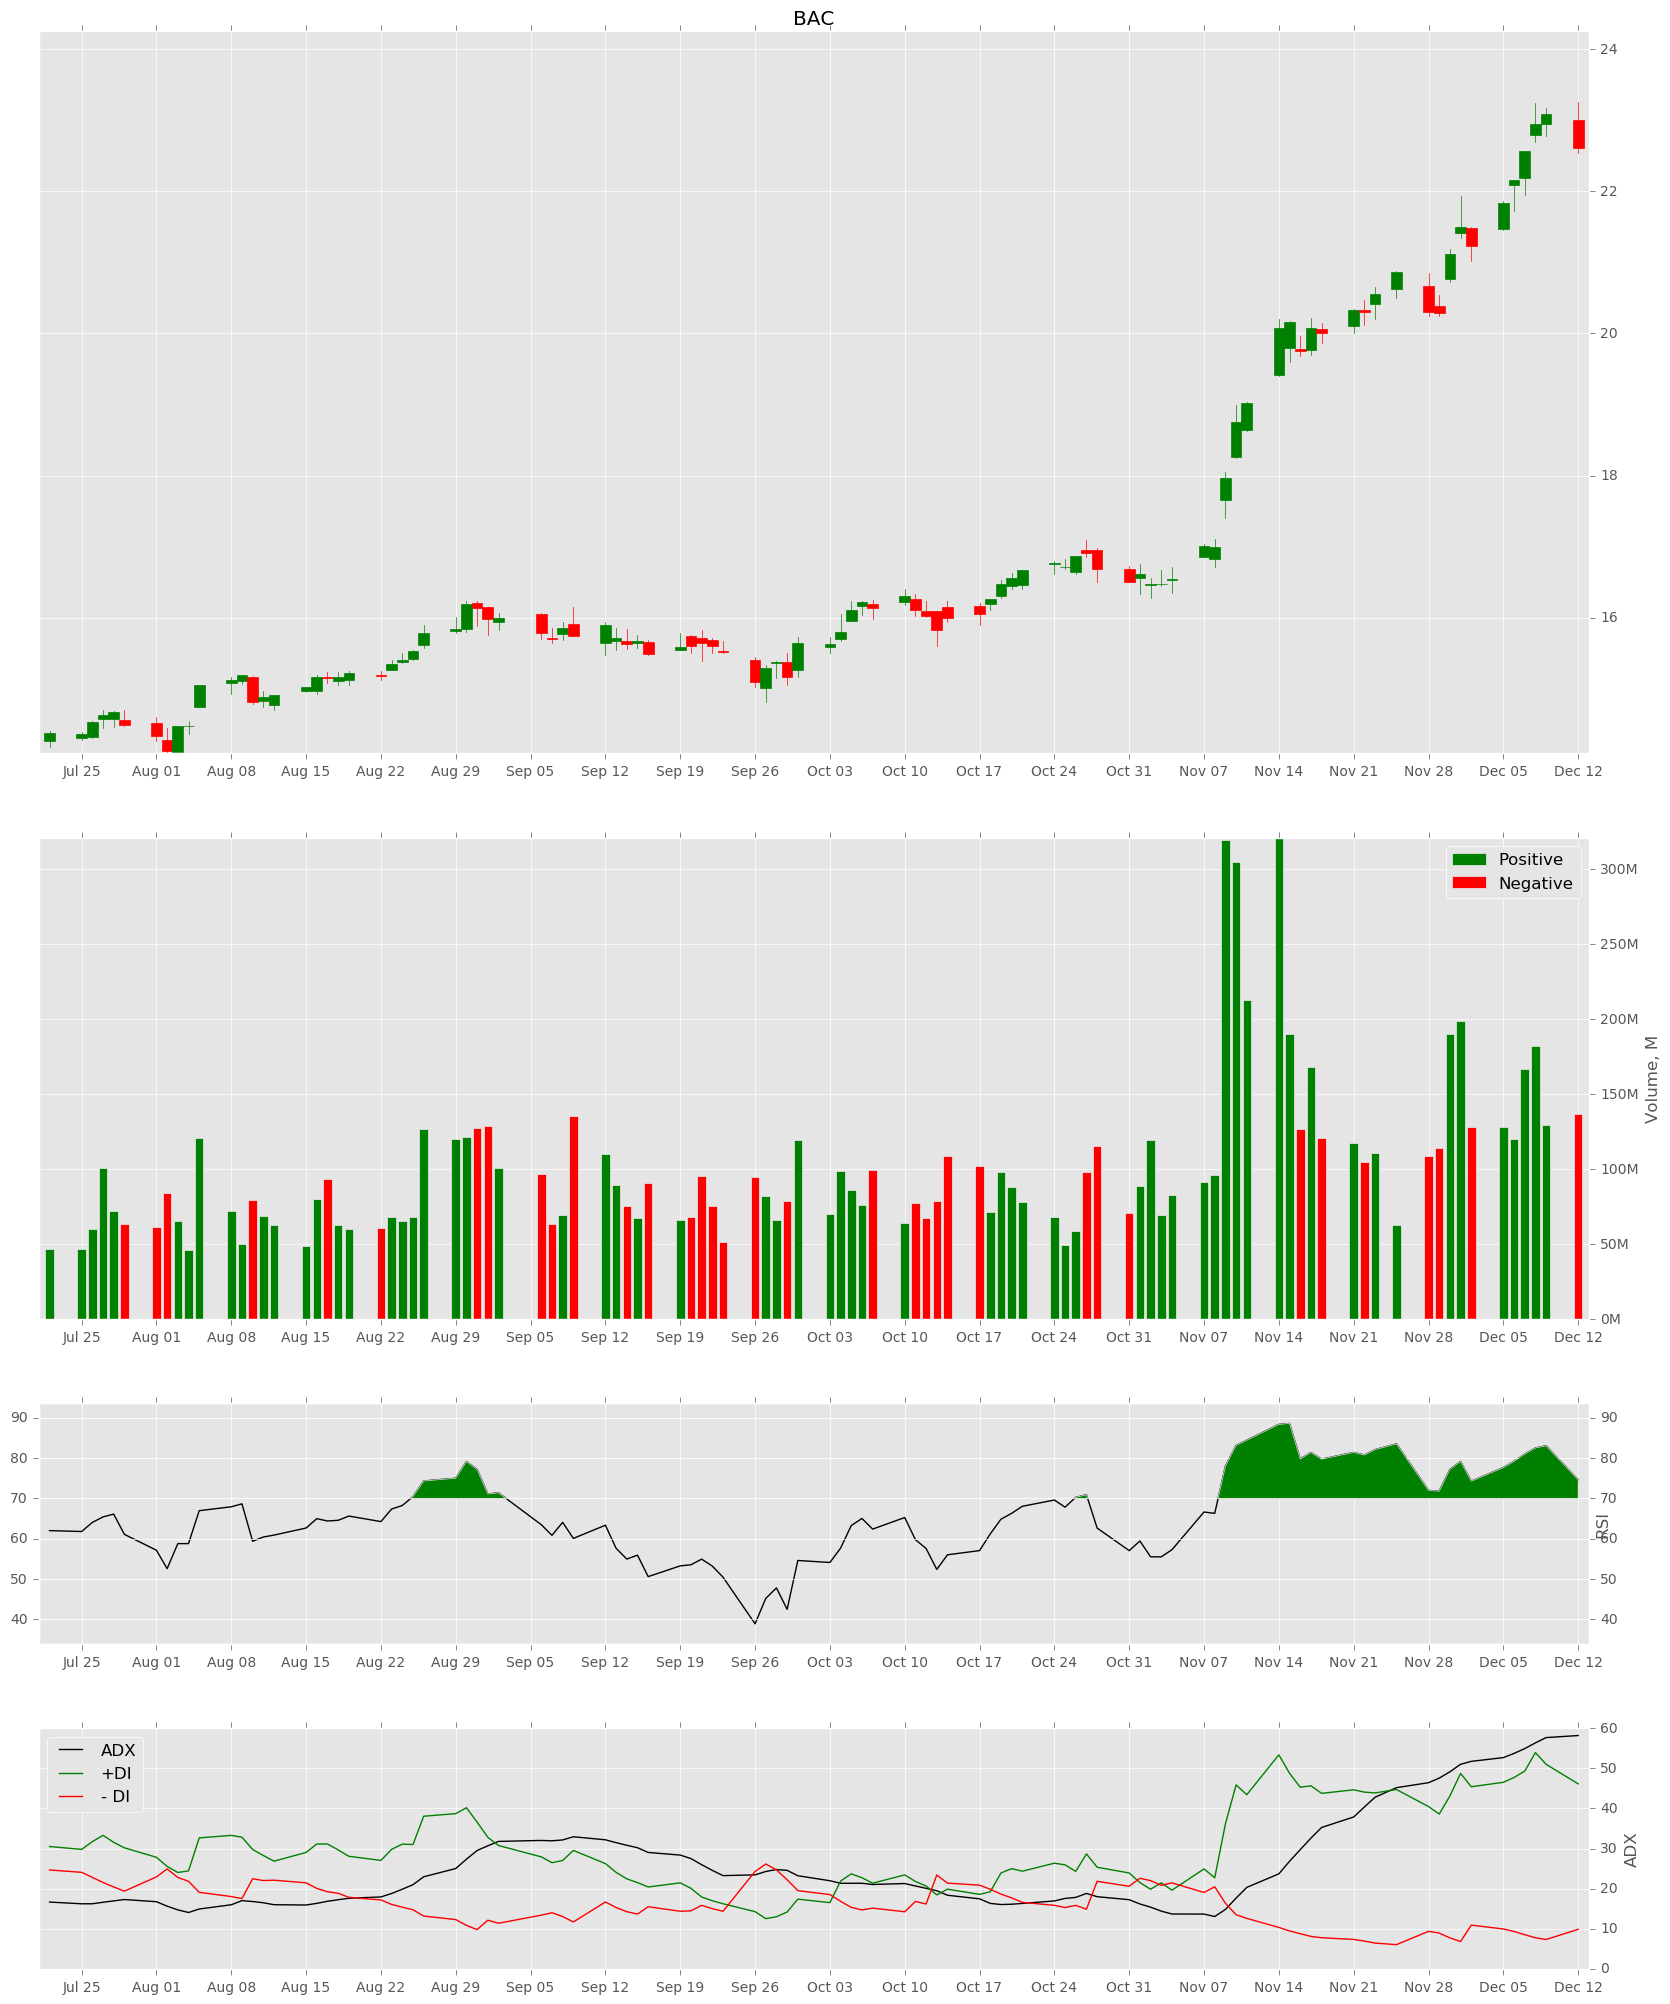

In [9]:
plot_data('BAC', df[-100:])

# PATTERN IDENTIFICATION ALGORITHM

Patter conditions:
1. Identify gaps of over 3% (opening price > 3% than closing price of the previous day)  ’If YES’ and 

2. Gap day close price should make a new 90 days high ’If YES’ and 

3. Gap day volume should be 50% higher than the average of the previous 5 days ’If YES’ and 

4. RSI should be higher than 70 ’If YES’ and 

5. ADX green line should be > ADX red lines ’If YES’ then:

In [10]:
# 1
df['OpeningGap'] = pd.Series((df.Open - df.Close.shift(1)) / df.Close.shift(1) * 100, index=df.index.values)
fdf = df[df.OpeningGap >= 3]
fdf[-3:][['Open', 'Close', 'OpeningGap']]

Open      Close  OpeningGap
Date                                    
2016-06-28  12.57  12.700000    3.201970
2016-11-09  17.66  17.969999    3.882353

In [11]:
# 2
df['Prev89daysMaxClose'] = df.Close.rolling(window=89).max()
df['MaxHigh90Days'] = df.Close > df.Prev89daysMaxClose.shift(1)
fdf = df[df.MaxHigh90Days] 
fdf[-3:][['MaxHigh90Days', 'Open', 'Close']]

MaxHigh90Days       Open      Close
Date                                          
2016-12-07          True  22.190001  22.570000
2016-12-08          True  22.790001  22.950001
2016-12-09          True  22.950001  23.090000

In [12]:
# 3
df['Recent5daysAvgVolume'] = df.Volume.rolling(window=5).mean()
df['VolumeGap'] = ((df.Volume - df.Recent5daysAvgVolume.shift(1)) / df.Recent5daysAvgVolume.shift(1))
fdf = df[df.VolumeGap > 0.5] 
fdf[-3:][['Volume', 'Recent5daysAvgVolume', 'VolumeGap']]

Volume  Recent5daysAvgVolume  VolumeGap
Date                                                  
2016-11-14  320959900           250851700.0   0.565841
2016-11-30  190151700           117286280.0   0.897527
2016-12-01  198909600           134907940.0   0.695932

In [13]:
# 4
fdf = df[df.RSI > 70]
fdf[-3:][['RSI']]

RSI
Date                 
2016-12-08  82.490547
2016-12-09  83.027485
2016-12-12  74.582677

In [14]:
# 5
fdf = df[df.PLUS_DI > df.MINUS_DI] 
fdf[-3:][['PLUS_DI', 'MINUS_DI', 'ADX']]

PLUS_DI  MINUS_DI        ADX
Date                                      
2016-12-08  53.917772  7.747442  56.340416
2016-12-09  51.006508  7.329123  57.664141
2016-12-12  46.123872  9.863342  58.171398

In [15]:
# now we are ready to get everything together

def get_data(key, days=365):
    date2 = dt.now().date()
    date1 = date2 - timedelta(days=days)

    df = get_data_yahoo(key, date1, date2)
    del df['Adj Close']
    
    rsi_values = talib.RSI(df['Close'].values, timeperiod=14)
    df['RSI'] = pd.Series(rsi_values, index=df.index.values)
    
    adx_values = talib.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['ADX'] = pd.Series(adx_values, index=df.index.values)
    
    plus_di_values = talib.PLUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['PLUS_DI'] = pd.Series(plus_di_values, index=df.index.values)
    
    minus_di_values = talib.MINUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['MINUS_DI'] = pd.Series(minus_di_values, index=df.index.values)
    return df


def get_pattern_instances(df):
    # get additional filter fields
    df['OpeningGap'] = pd.Series((df.Open - df.Close.shift(1)) / df.Close.shift(1) * 100, index=df.index.values)    
    df['Recent5daysAvgVolume'] = df.Volume.rolling(window=5).mean()
    df['VolumeGap'] = ((df.Volume - df.Recent5daysAvgVolume.shift(1)) / df.Recent5daysAvgVolume.shift(1))    
    df['Prev89daysMaxClose'] = df.Close.rolling(window=89).max()
    df['MaxHigh90Days'] = df.Close > df.Prev89daysMaxClose.shift(1)    
    
    # apply filters
    df = df[df.MaxHigh90Days]     
    df = df[df.VolumeGap > 0.5] 
    df = df[df.OpeningGap >= 3]
    df = df[df.RSI > 70]
    df = df[df.PLUS_DI > df.MINUS_DI] 
    
    return df.index.tolist()

[Timestamp('2016-04-22 00:00:00'), Timestamp('2016-12-06 00:00:00'), Timestamp('2016-12-08 00:00:00')]


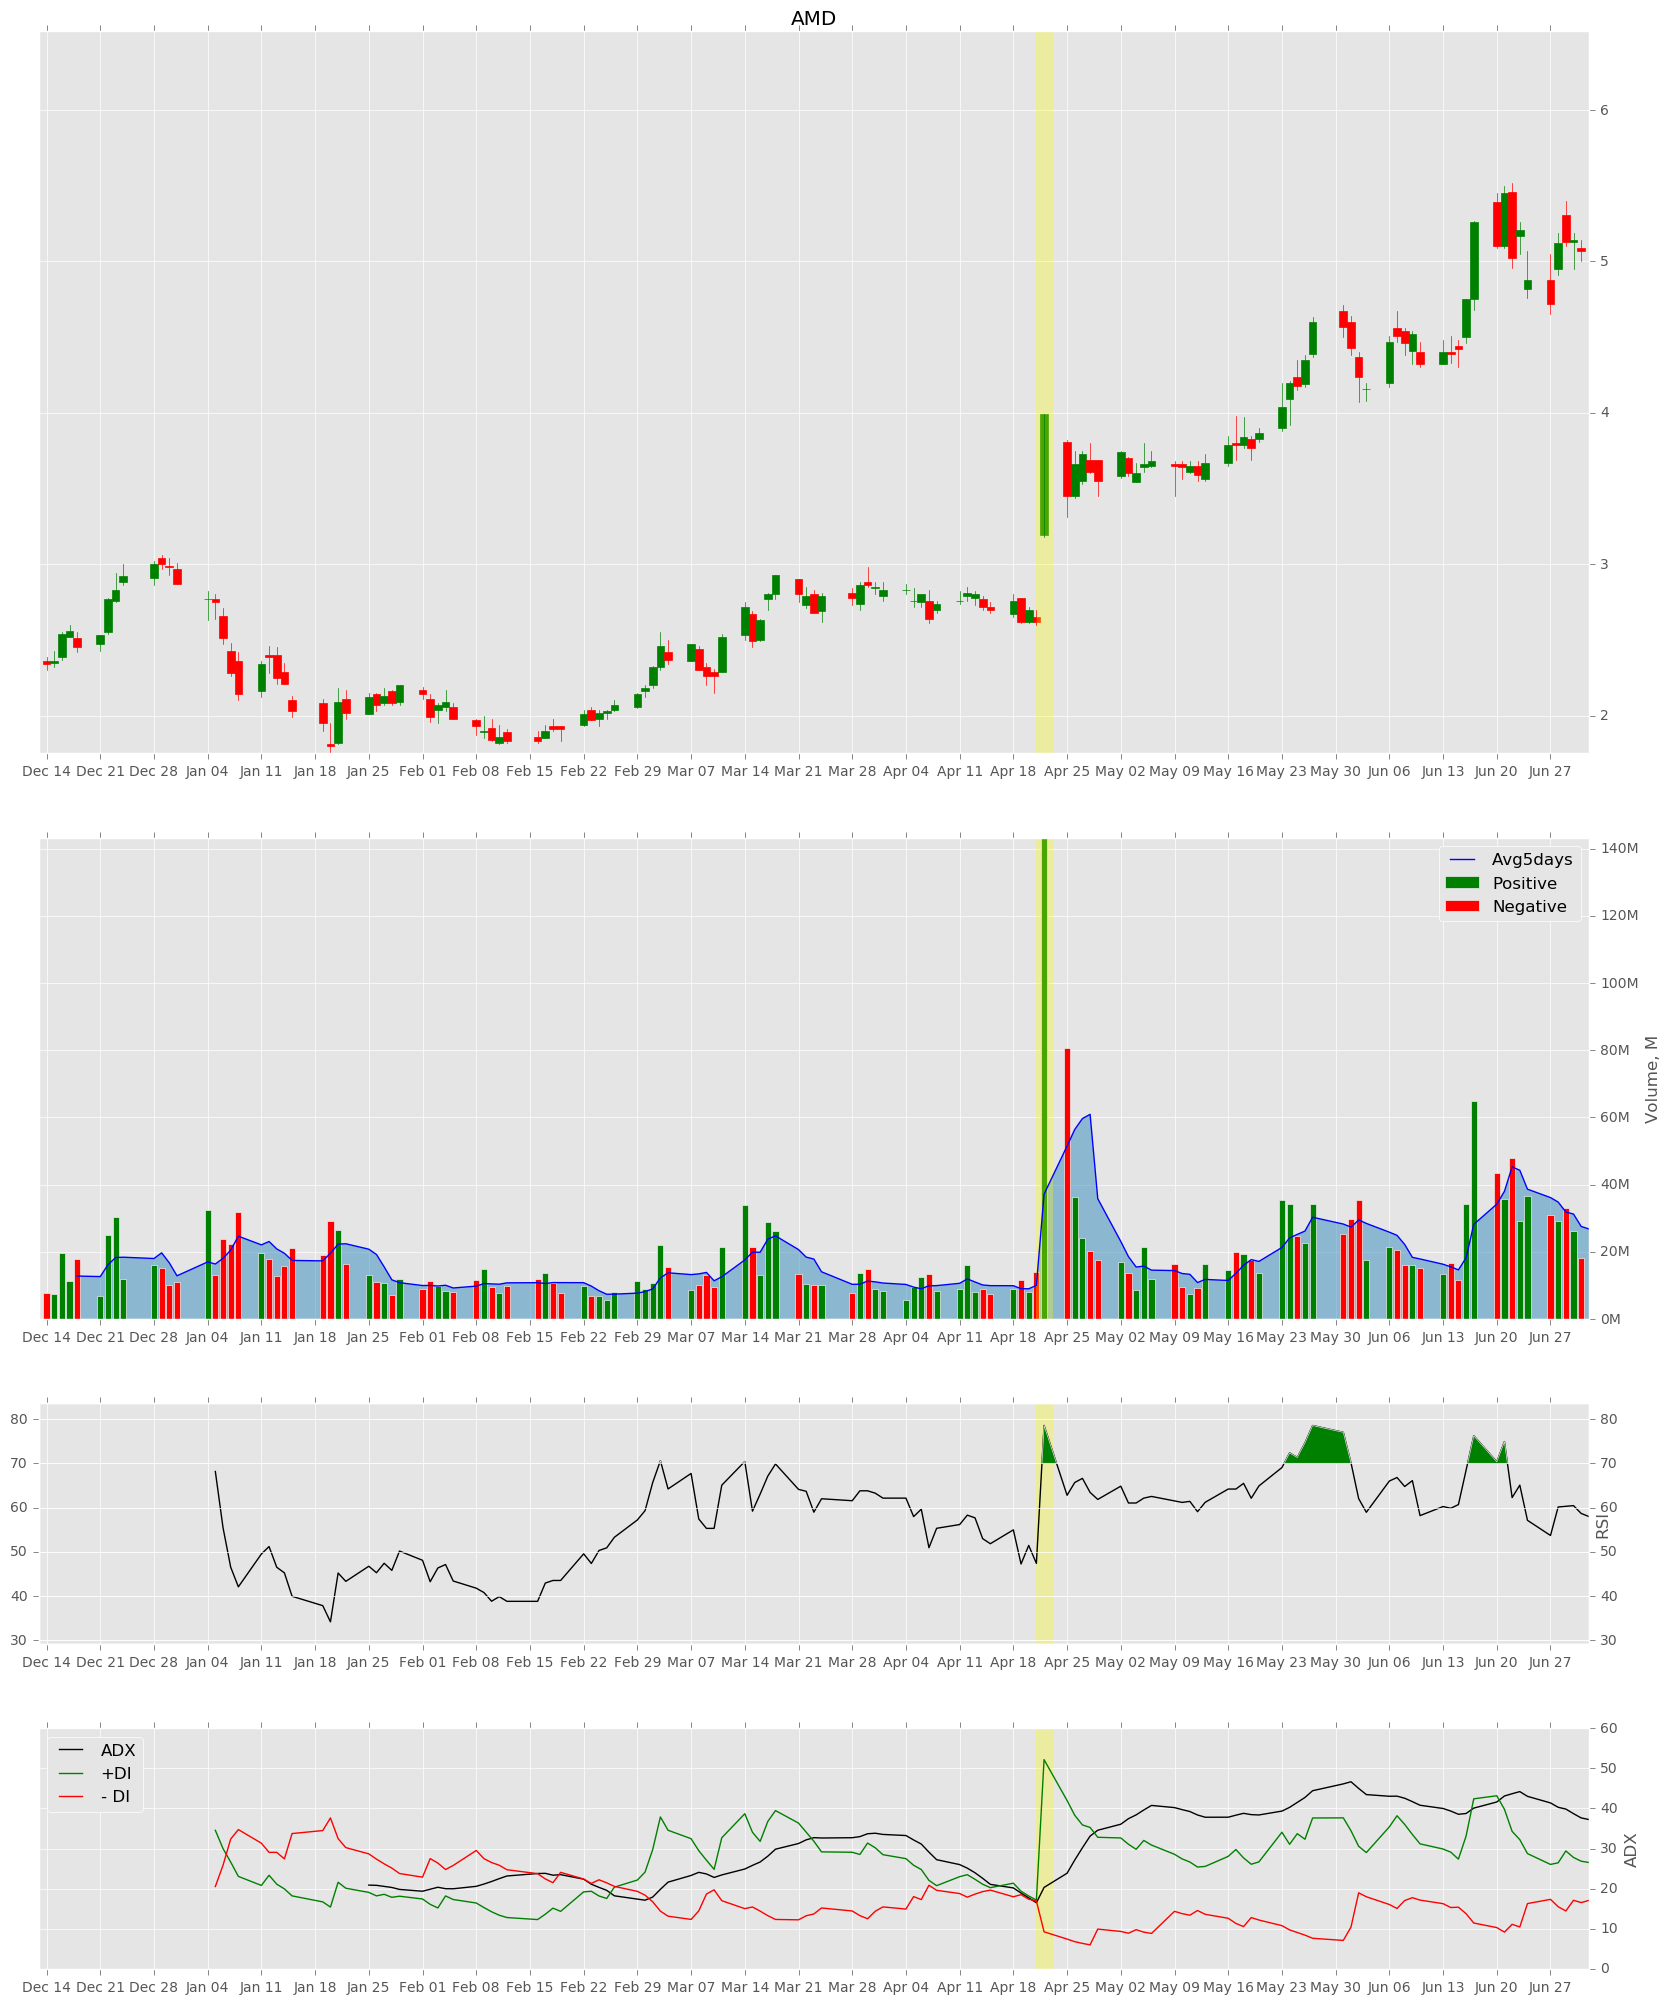

In [16]:
# Visualisation
data = get_data("AMD")
pattern_instances = get_pattern_instances(data)
print(pattern_instances)

plot_data('AMD', data, pattern_instances[0] if pattern_instances else None)

### Now lets get a few instances 


Found total of 11 instances


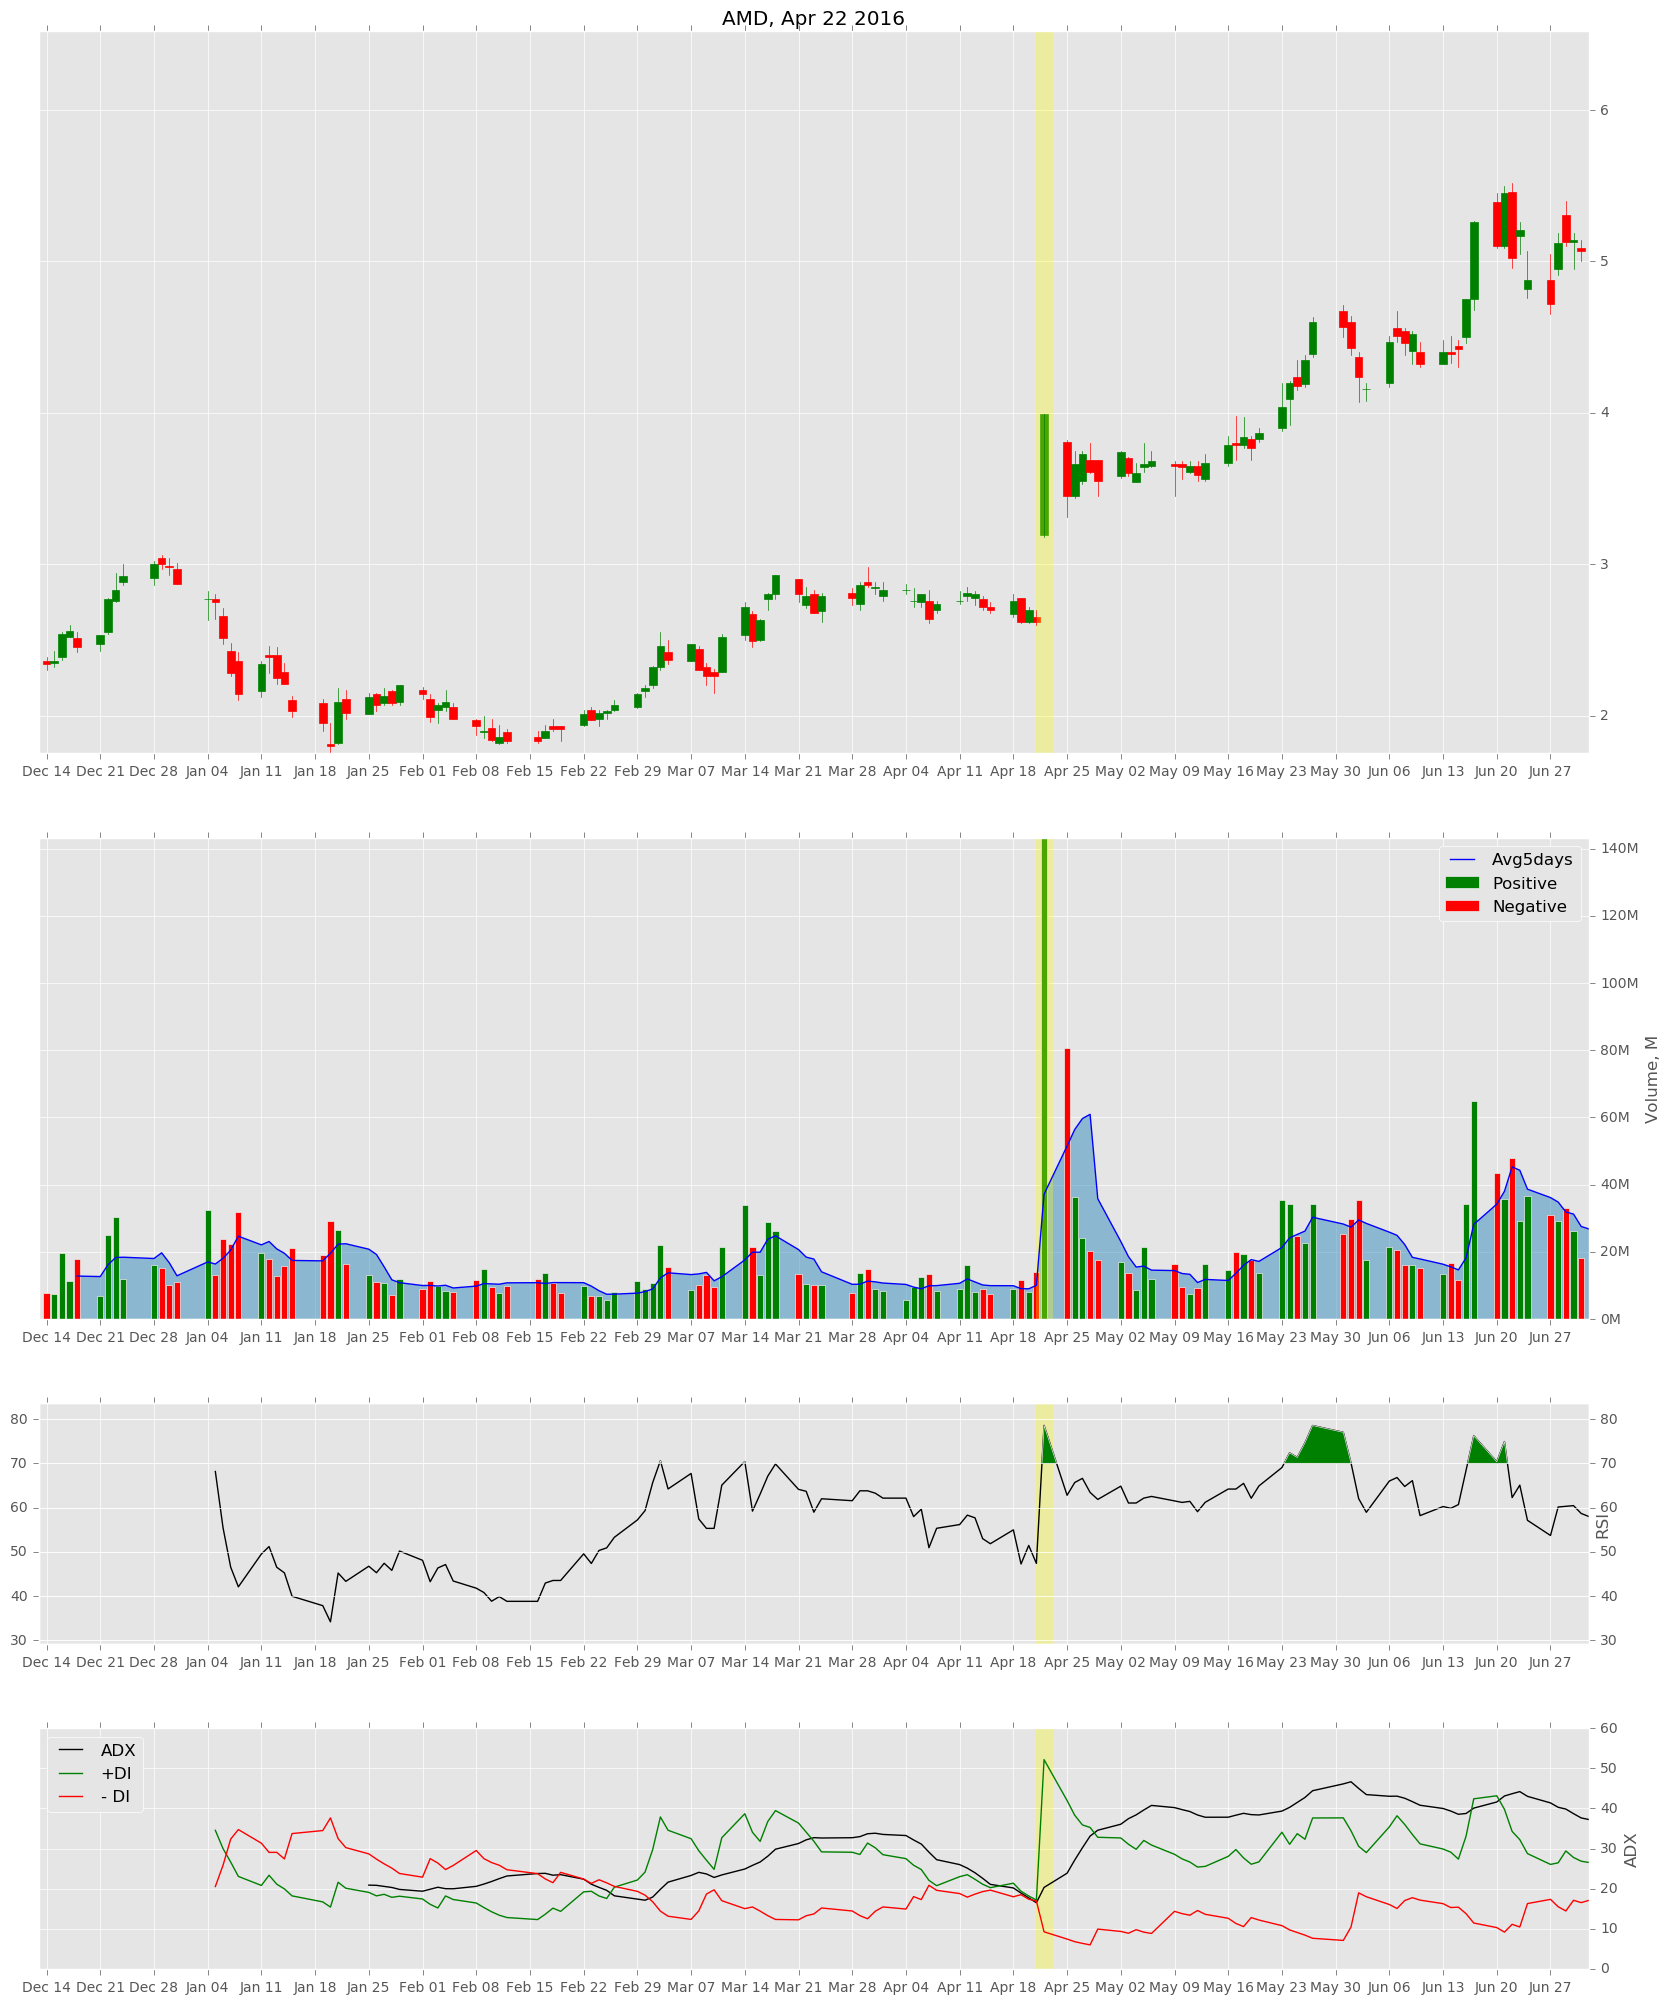

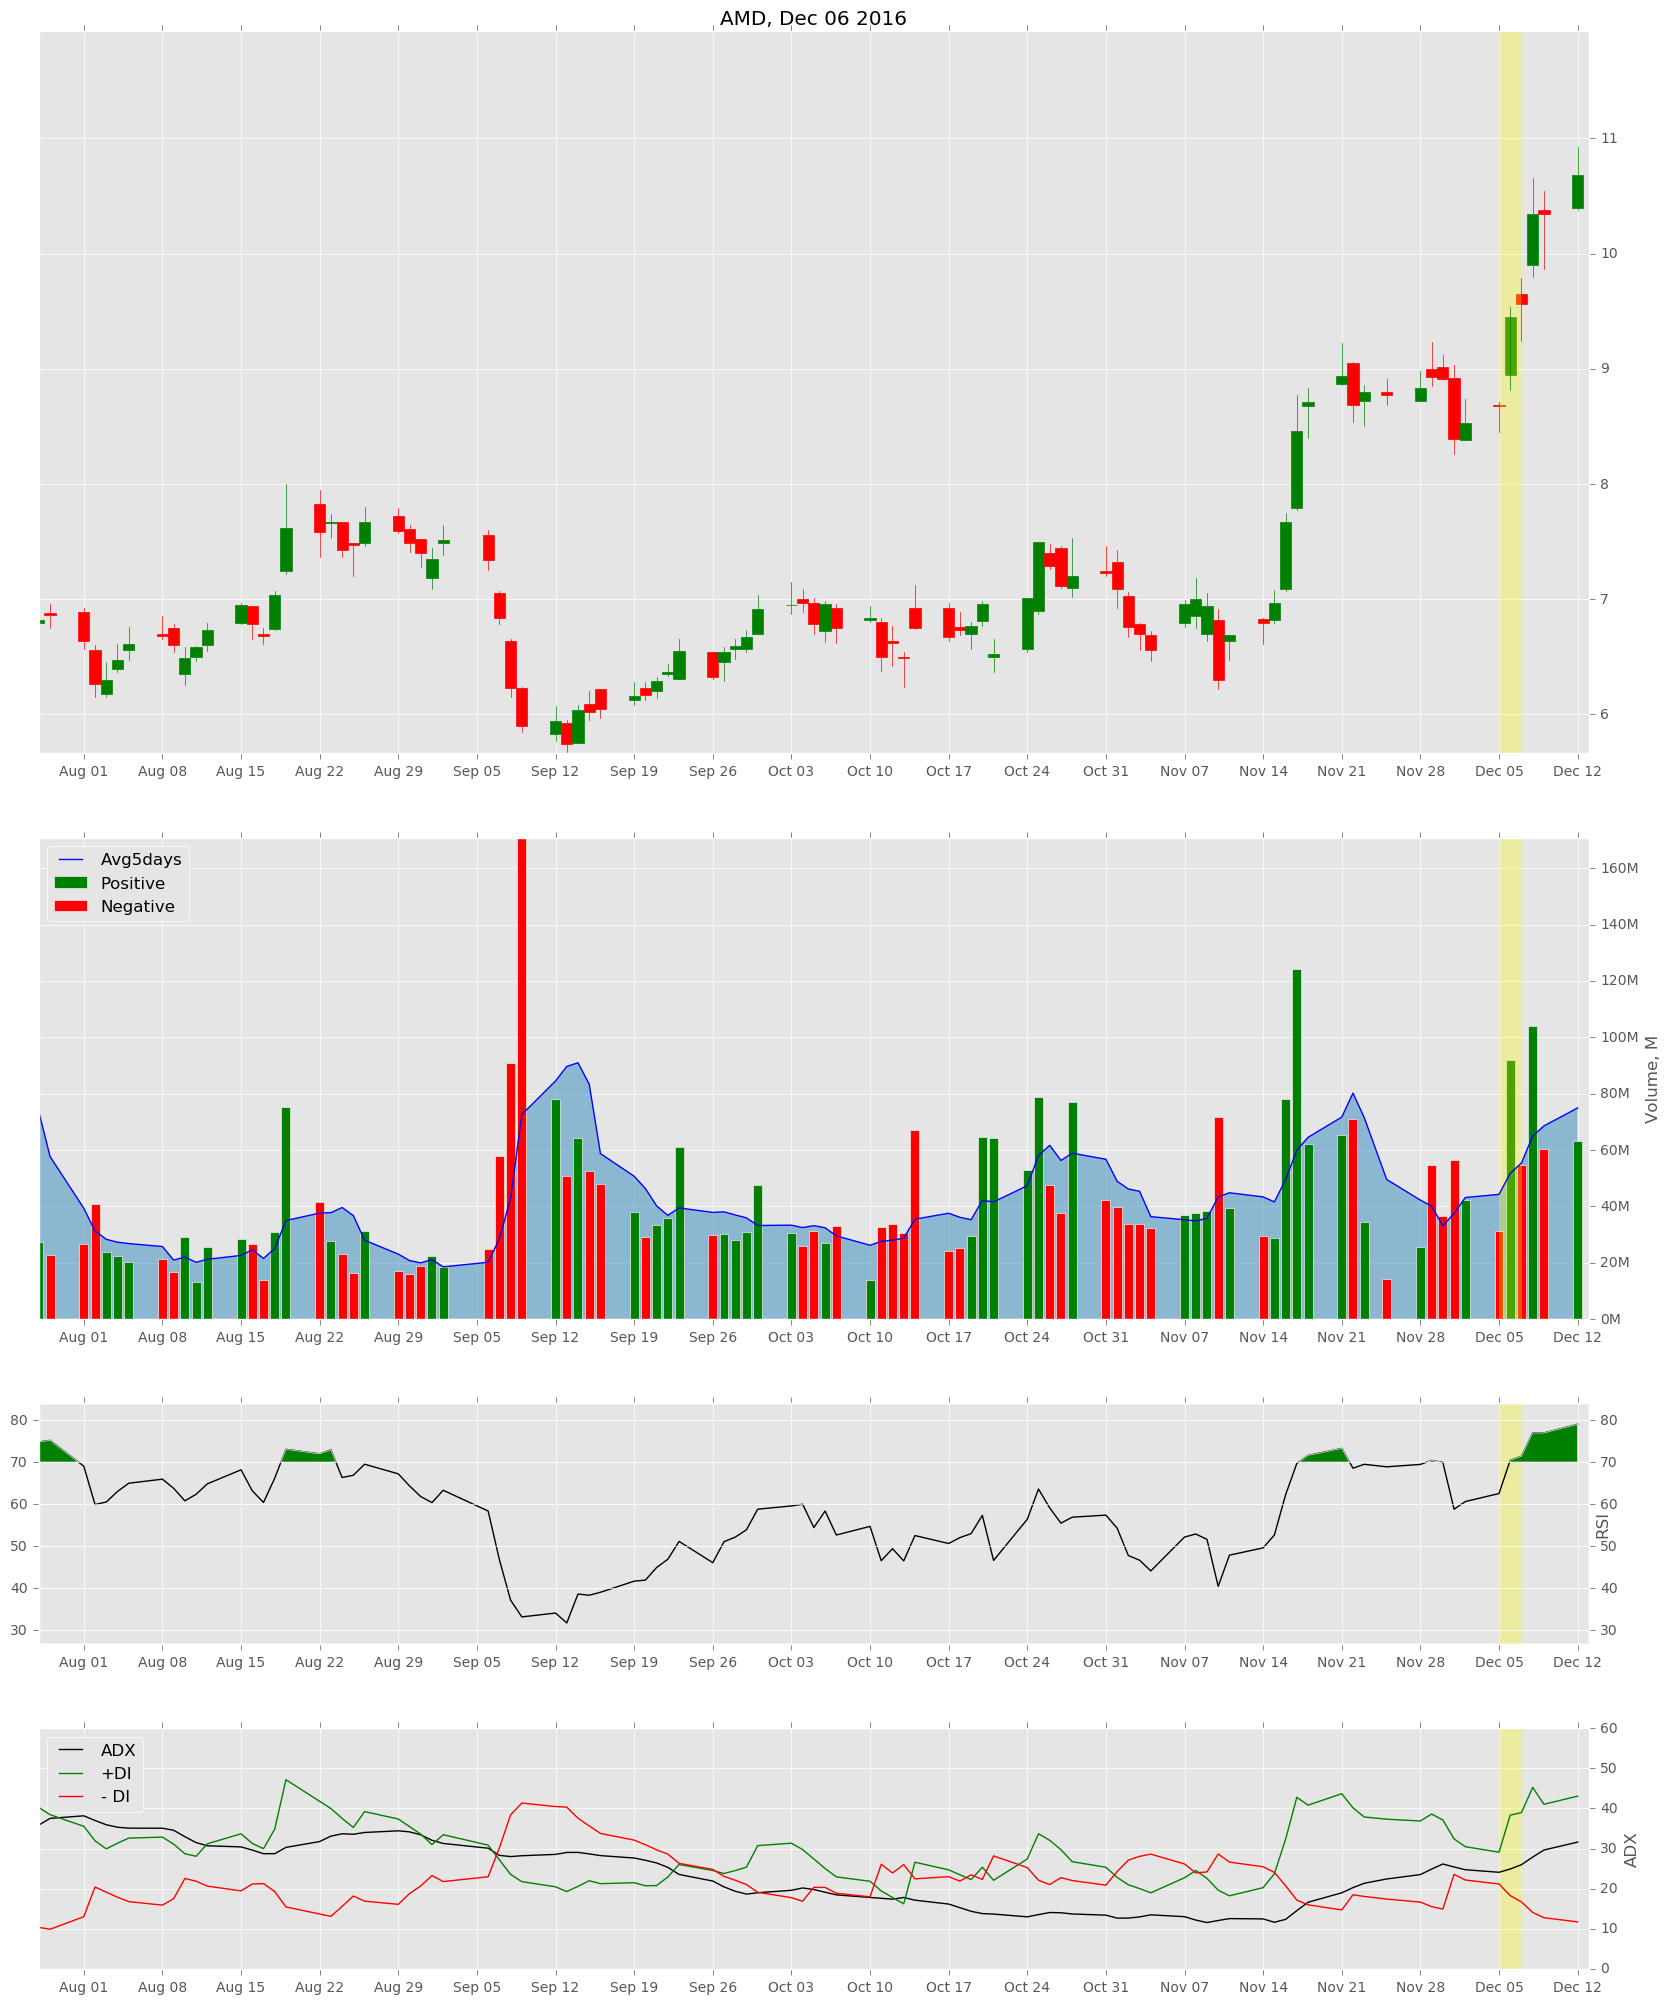

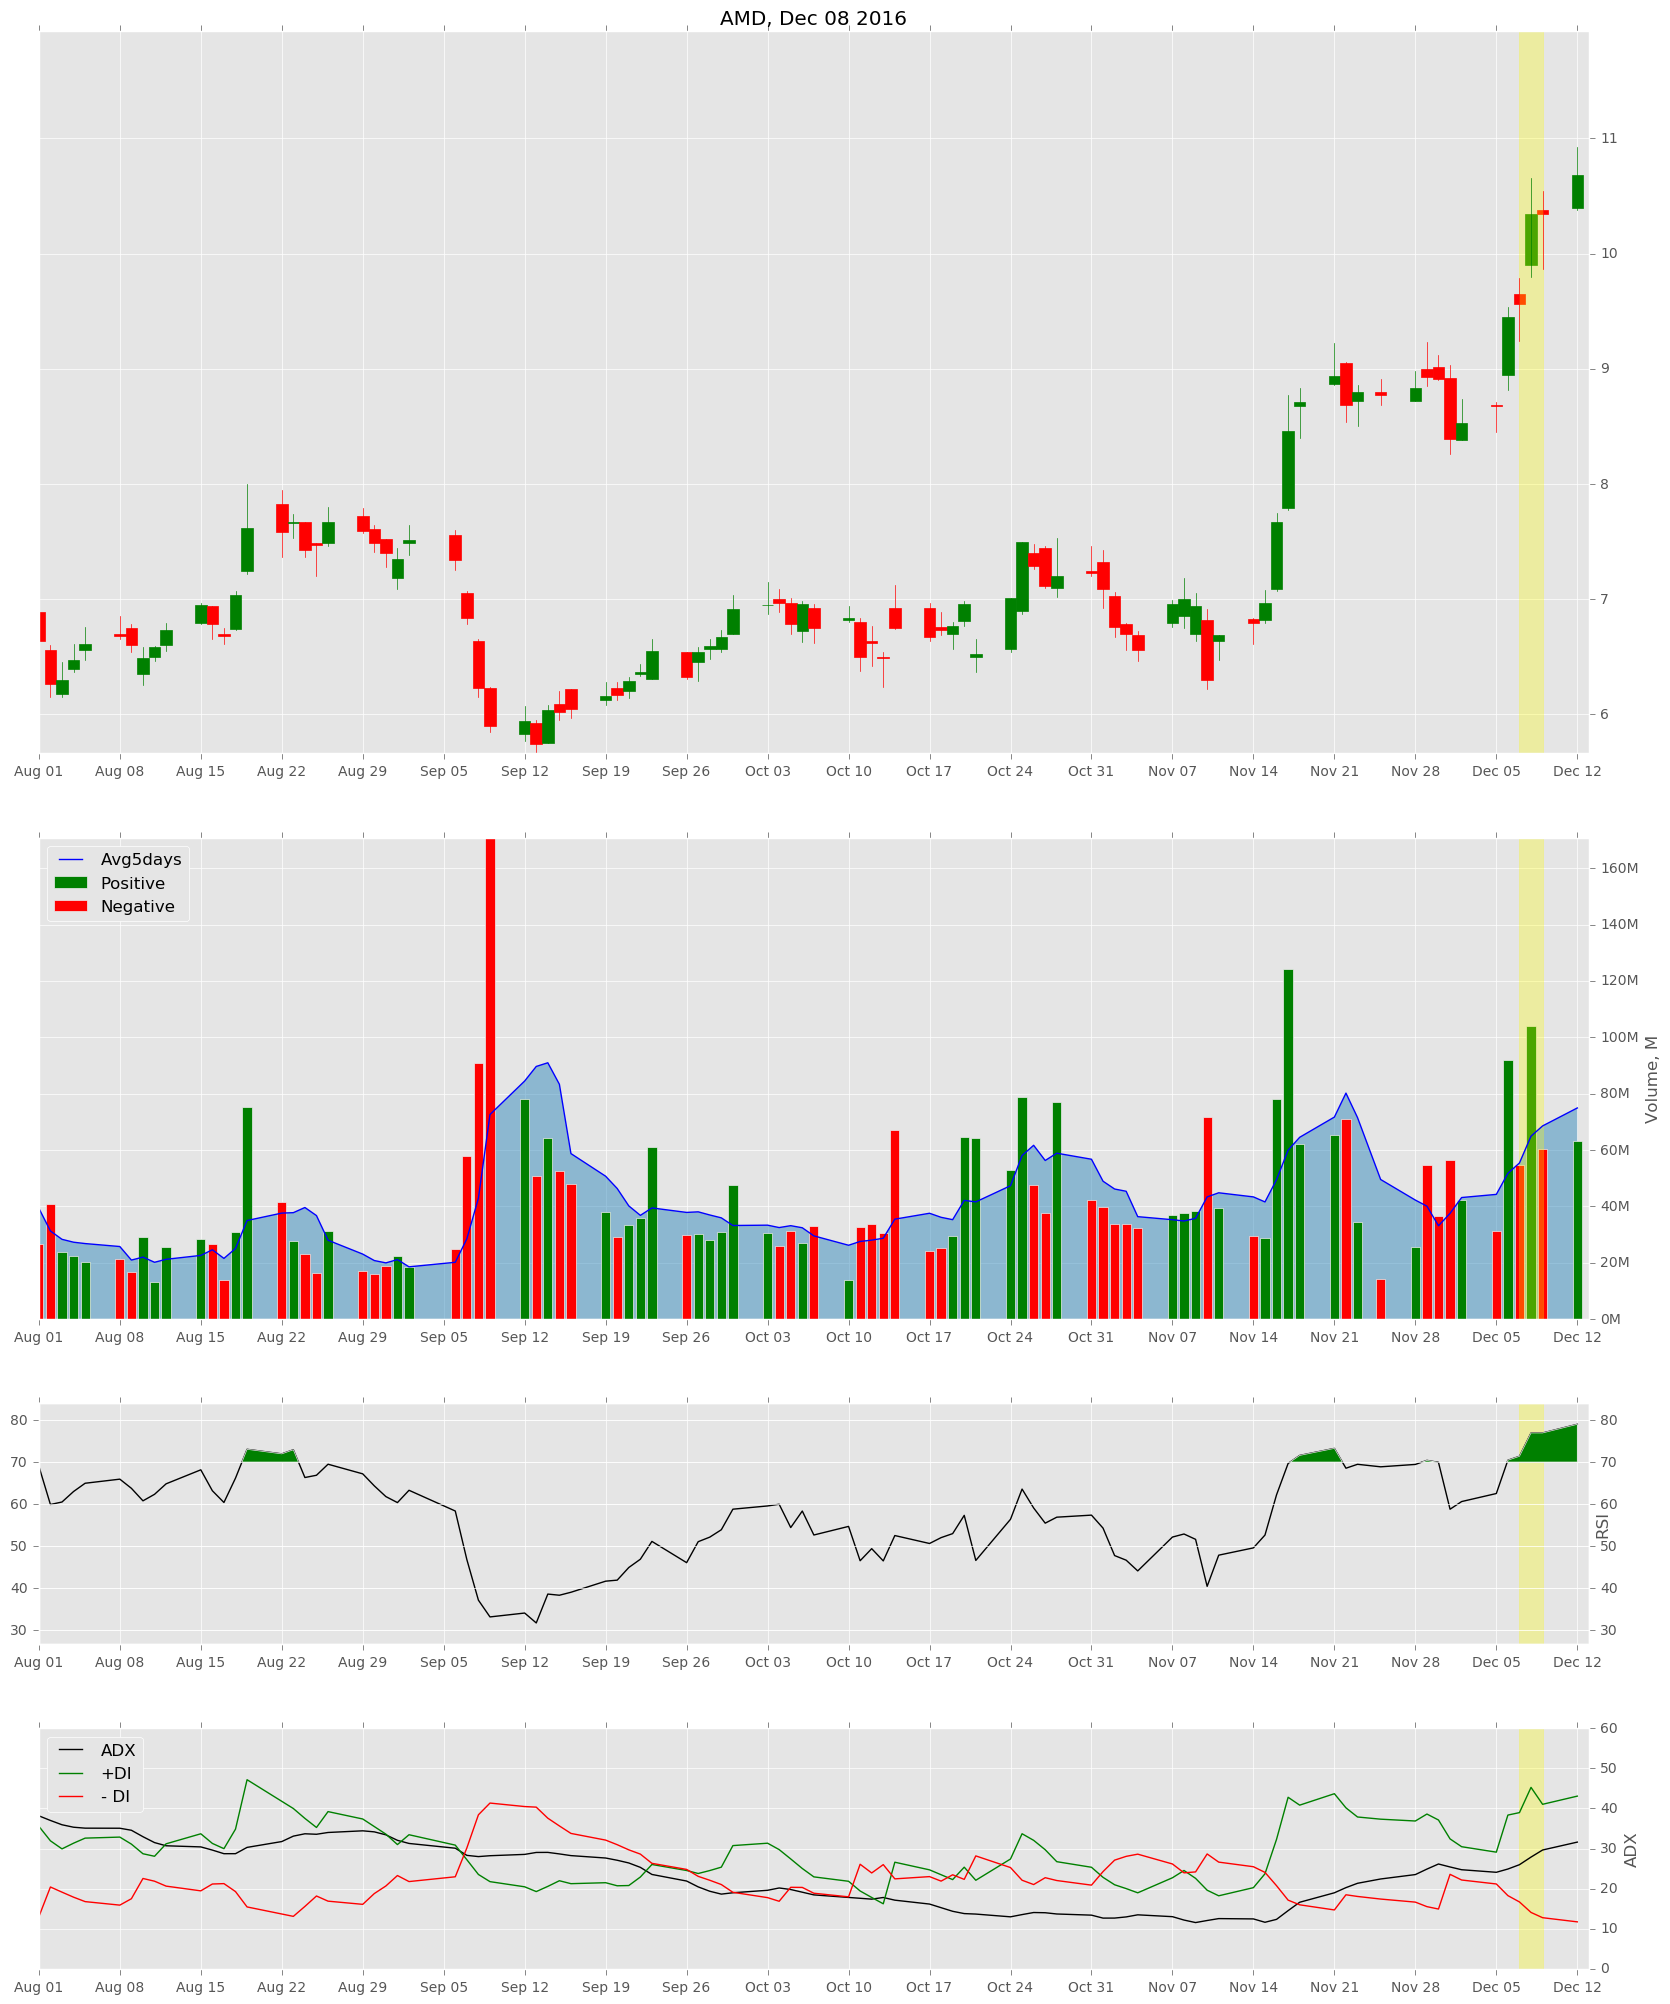

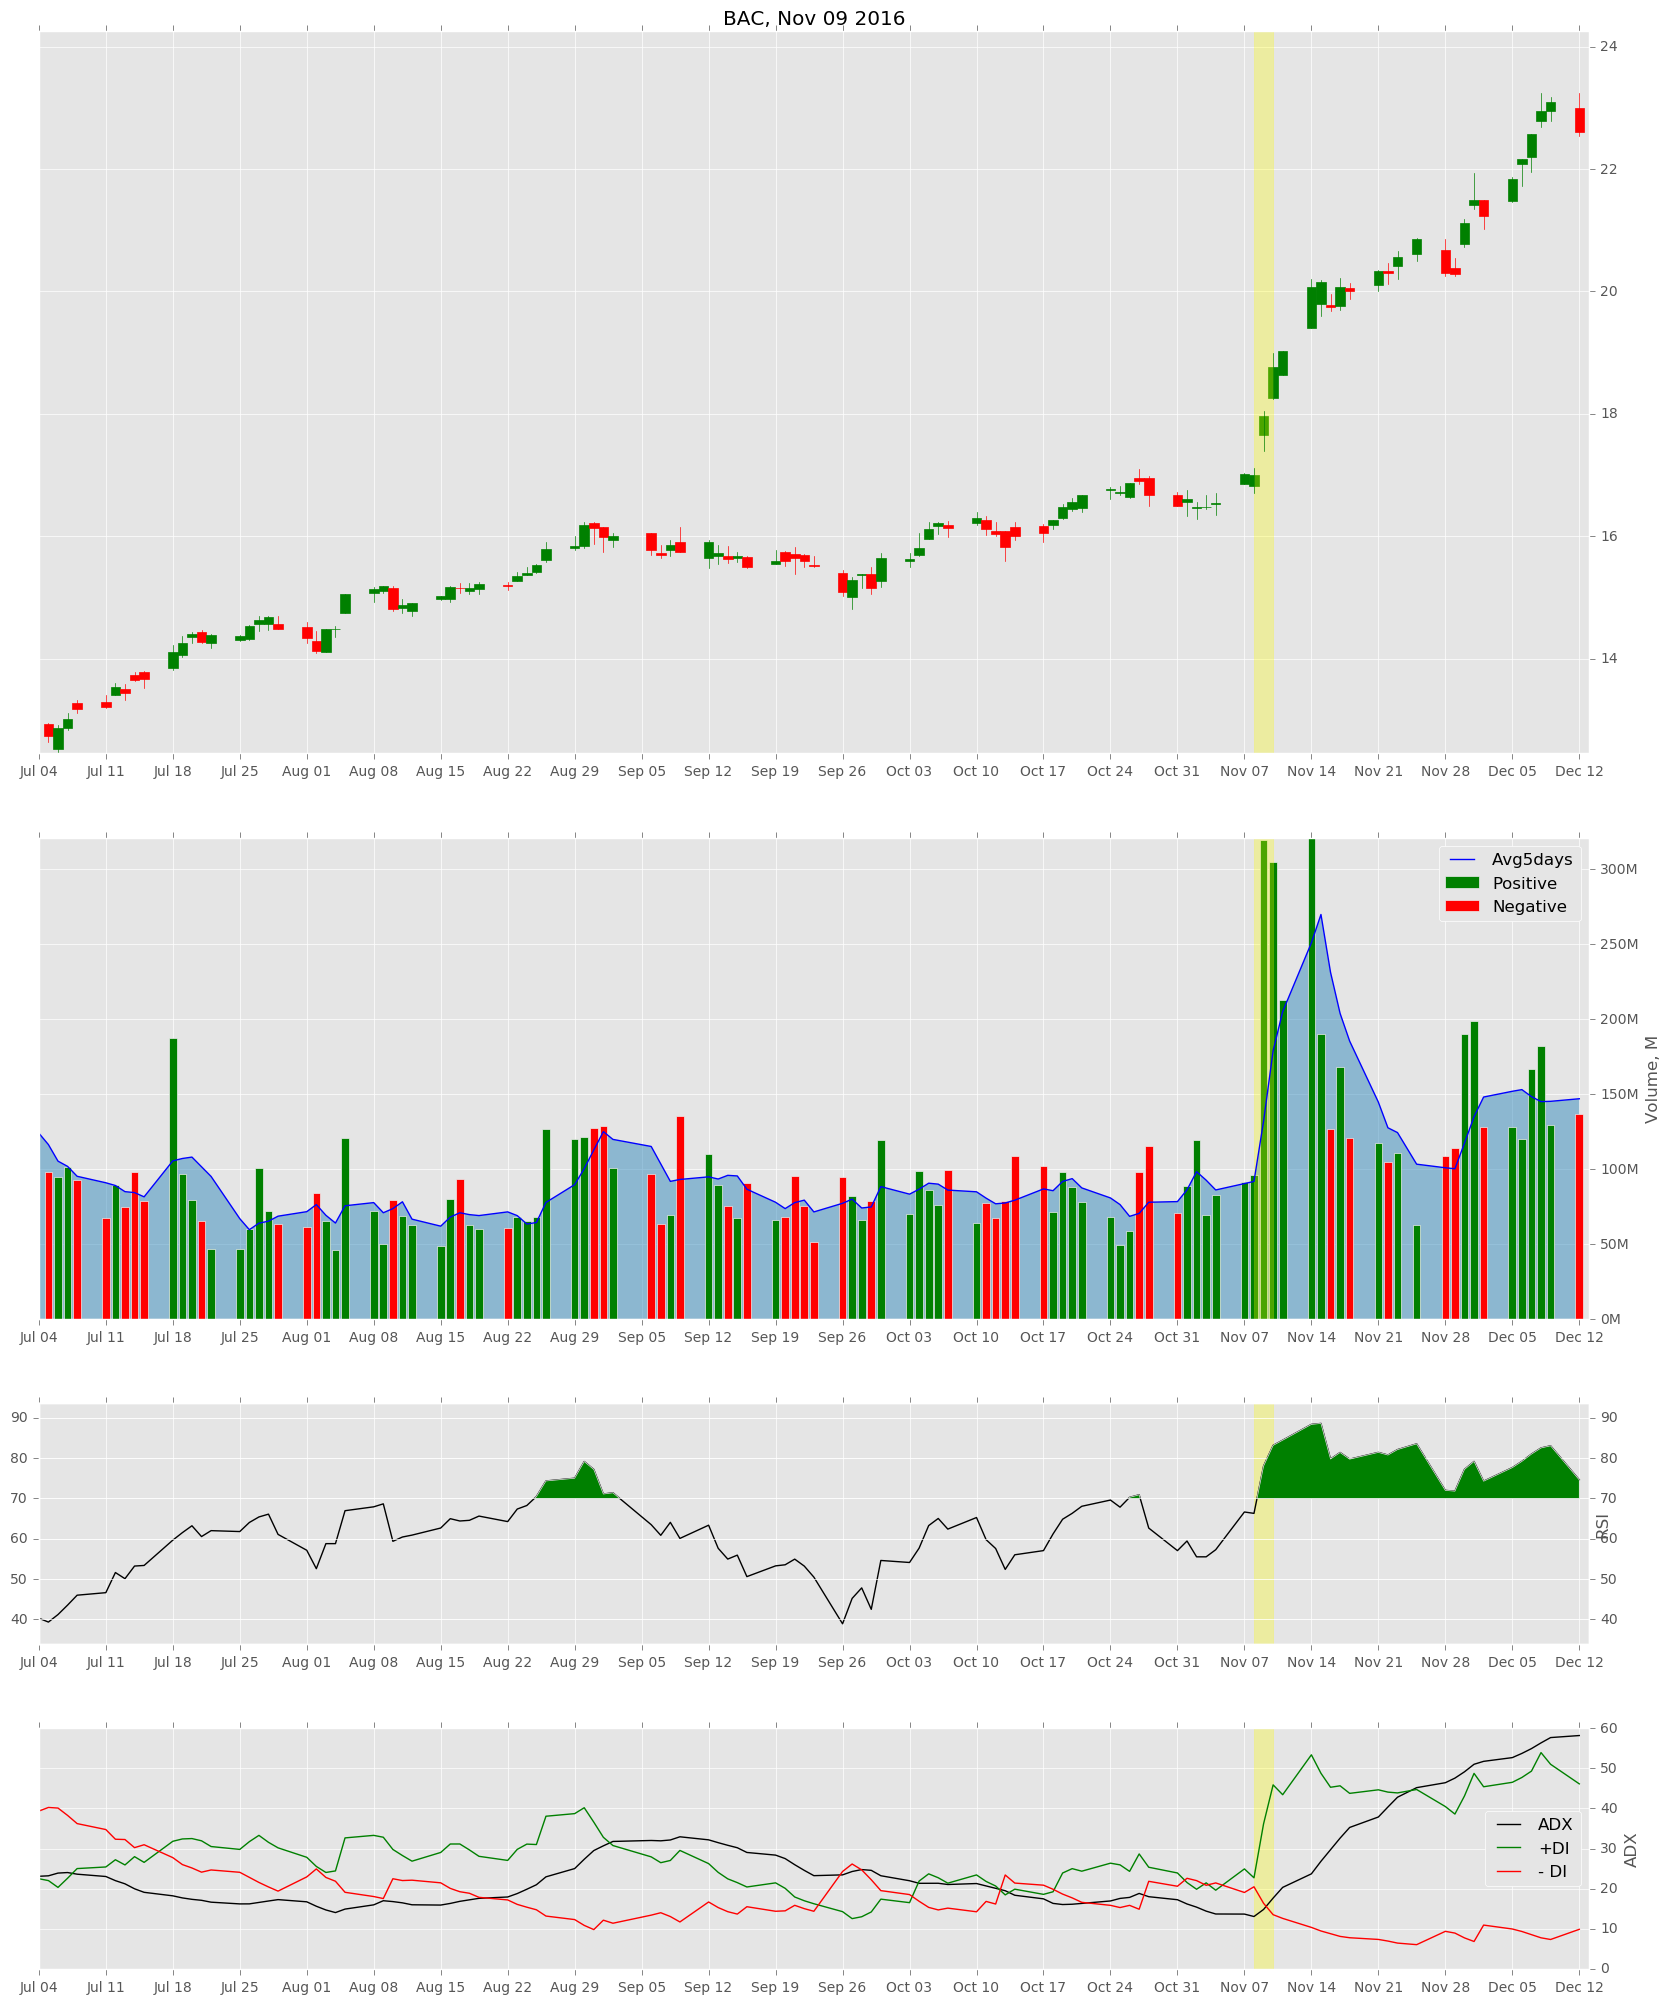

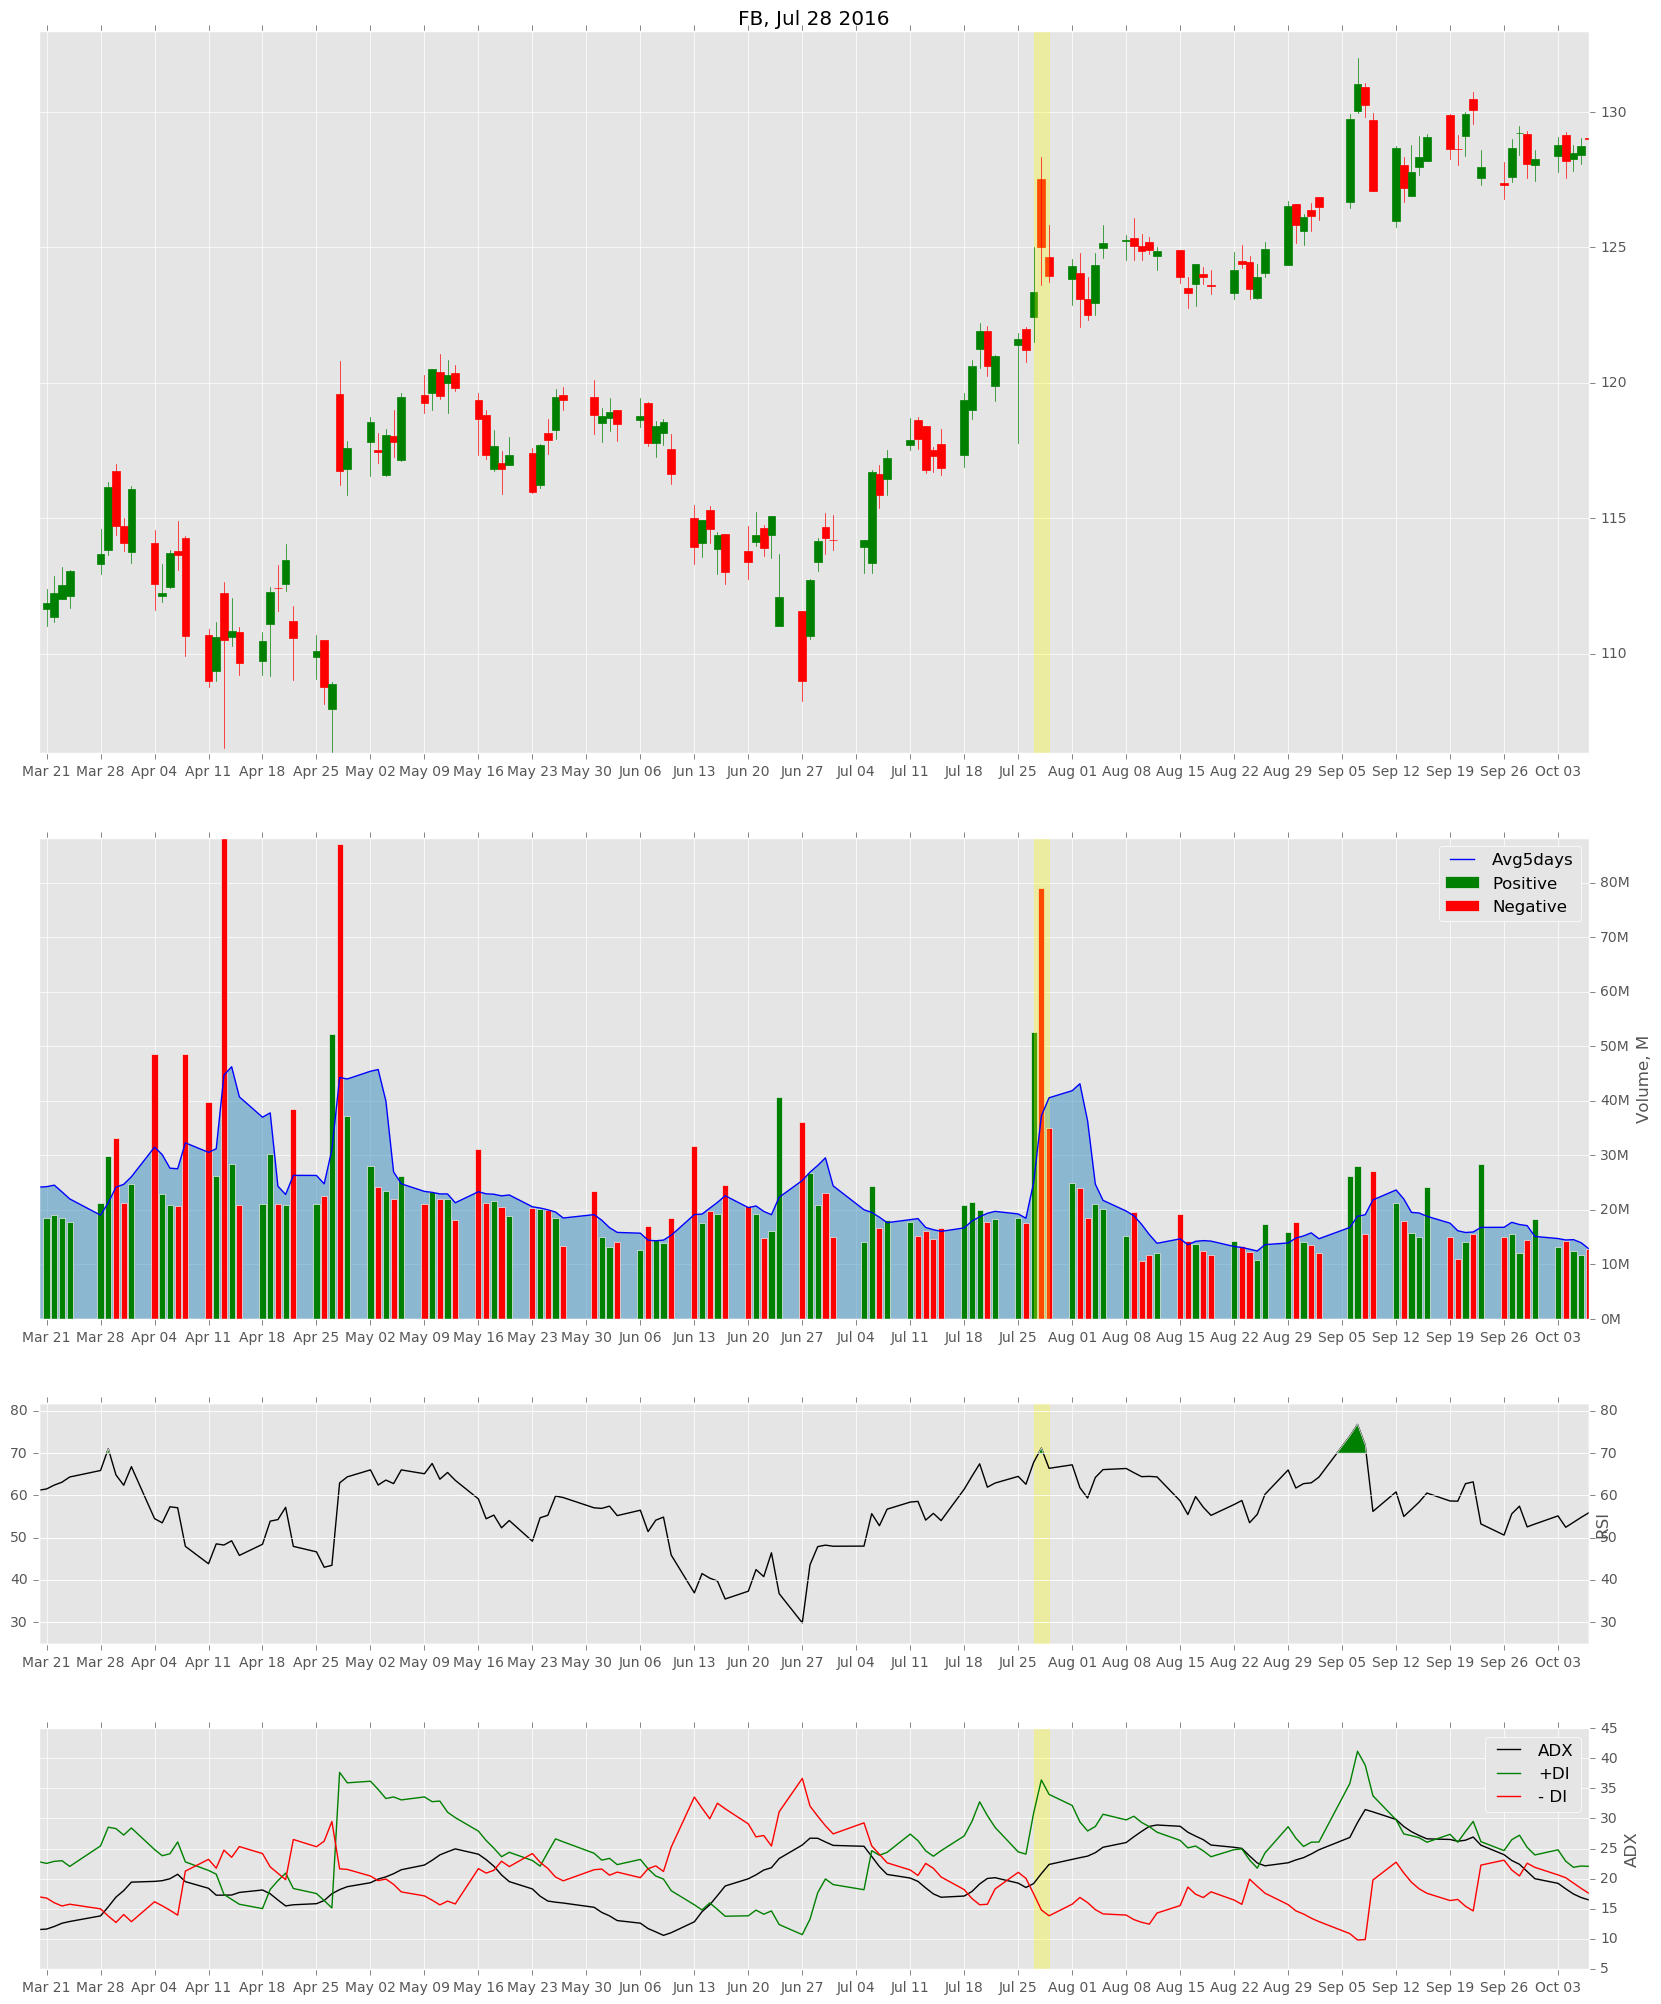

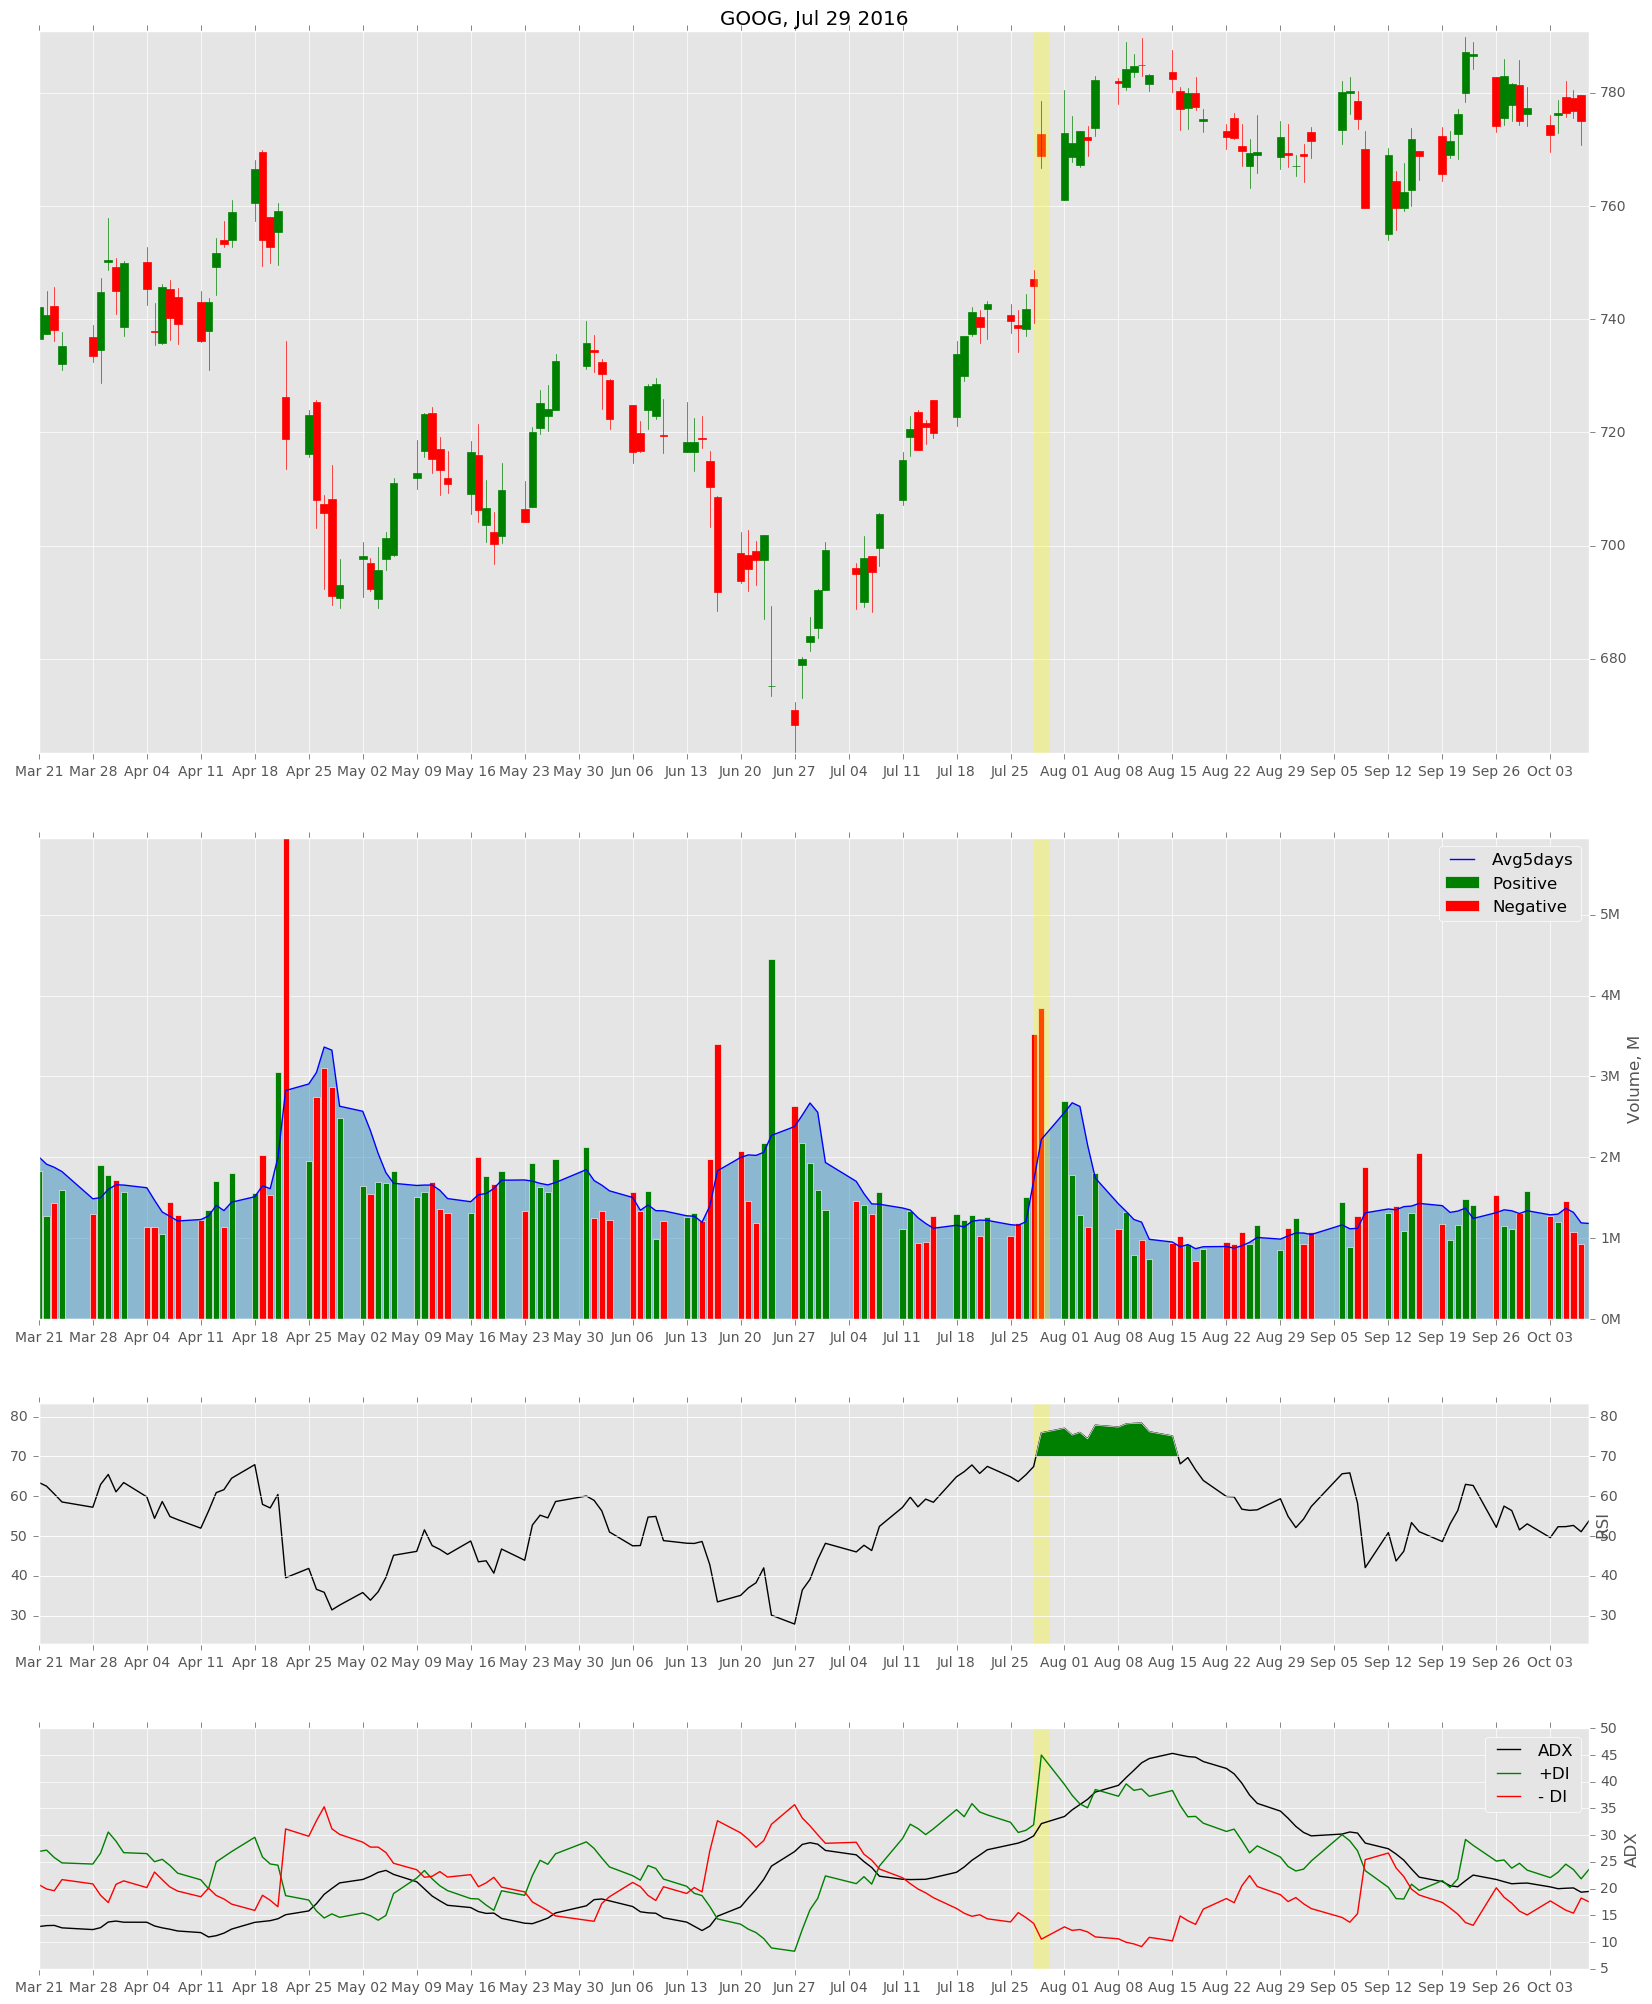

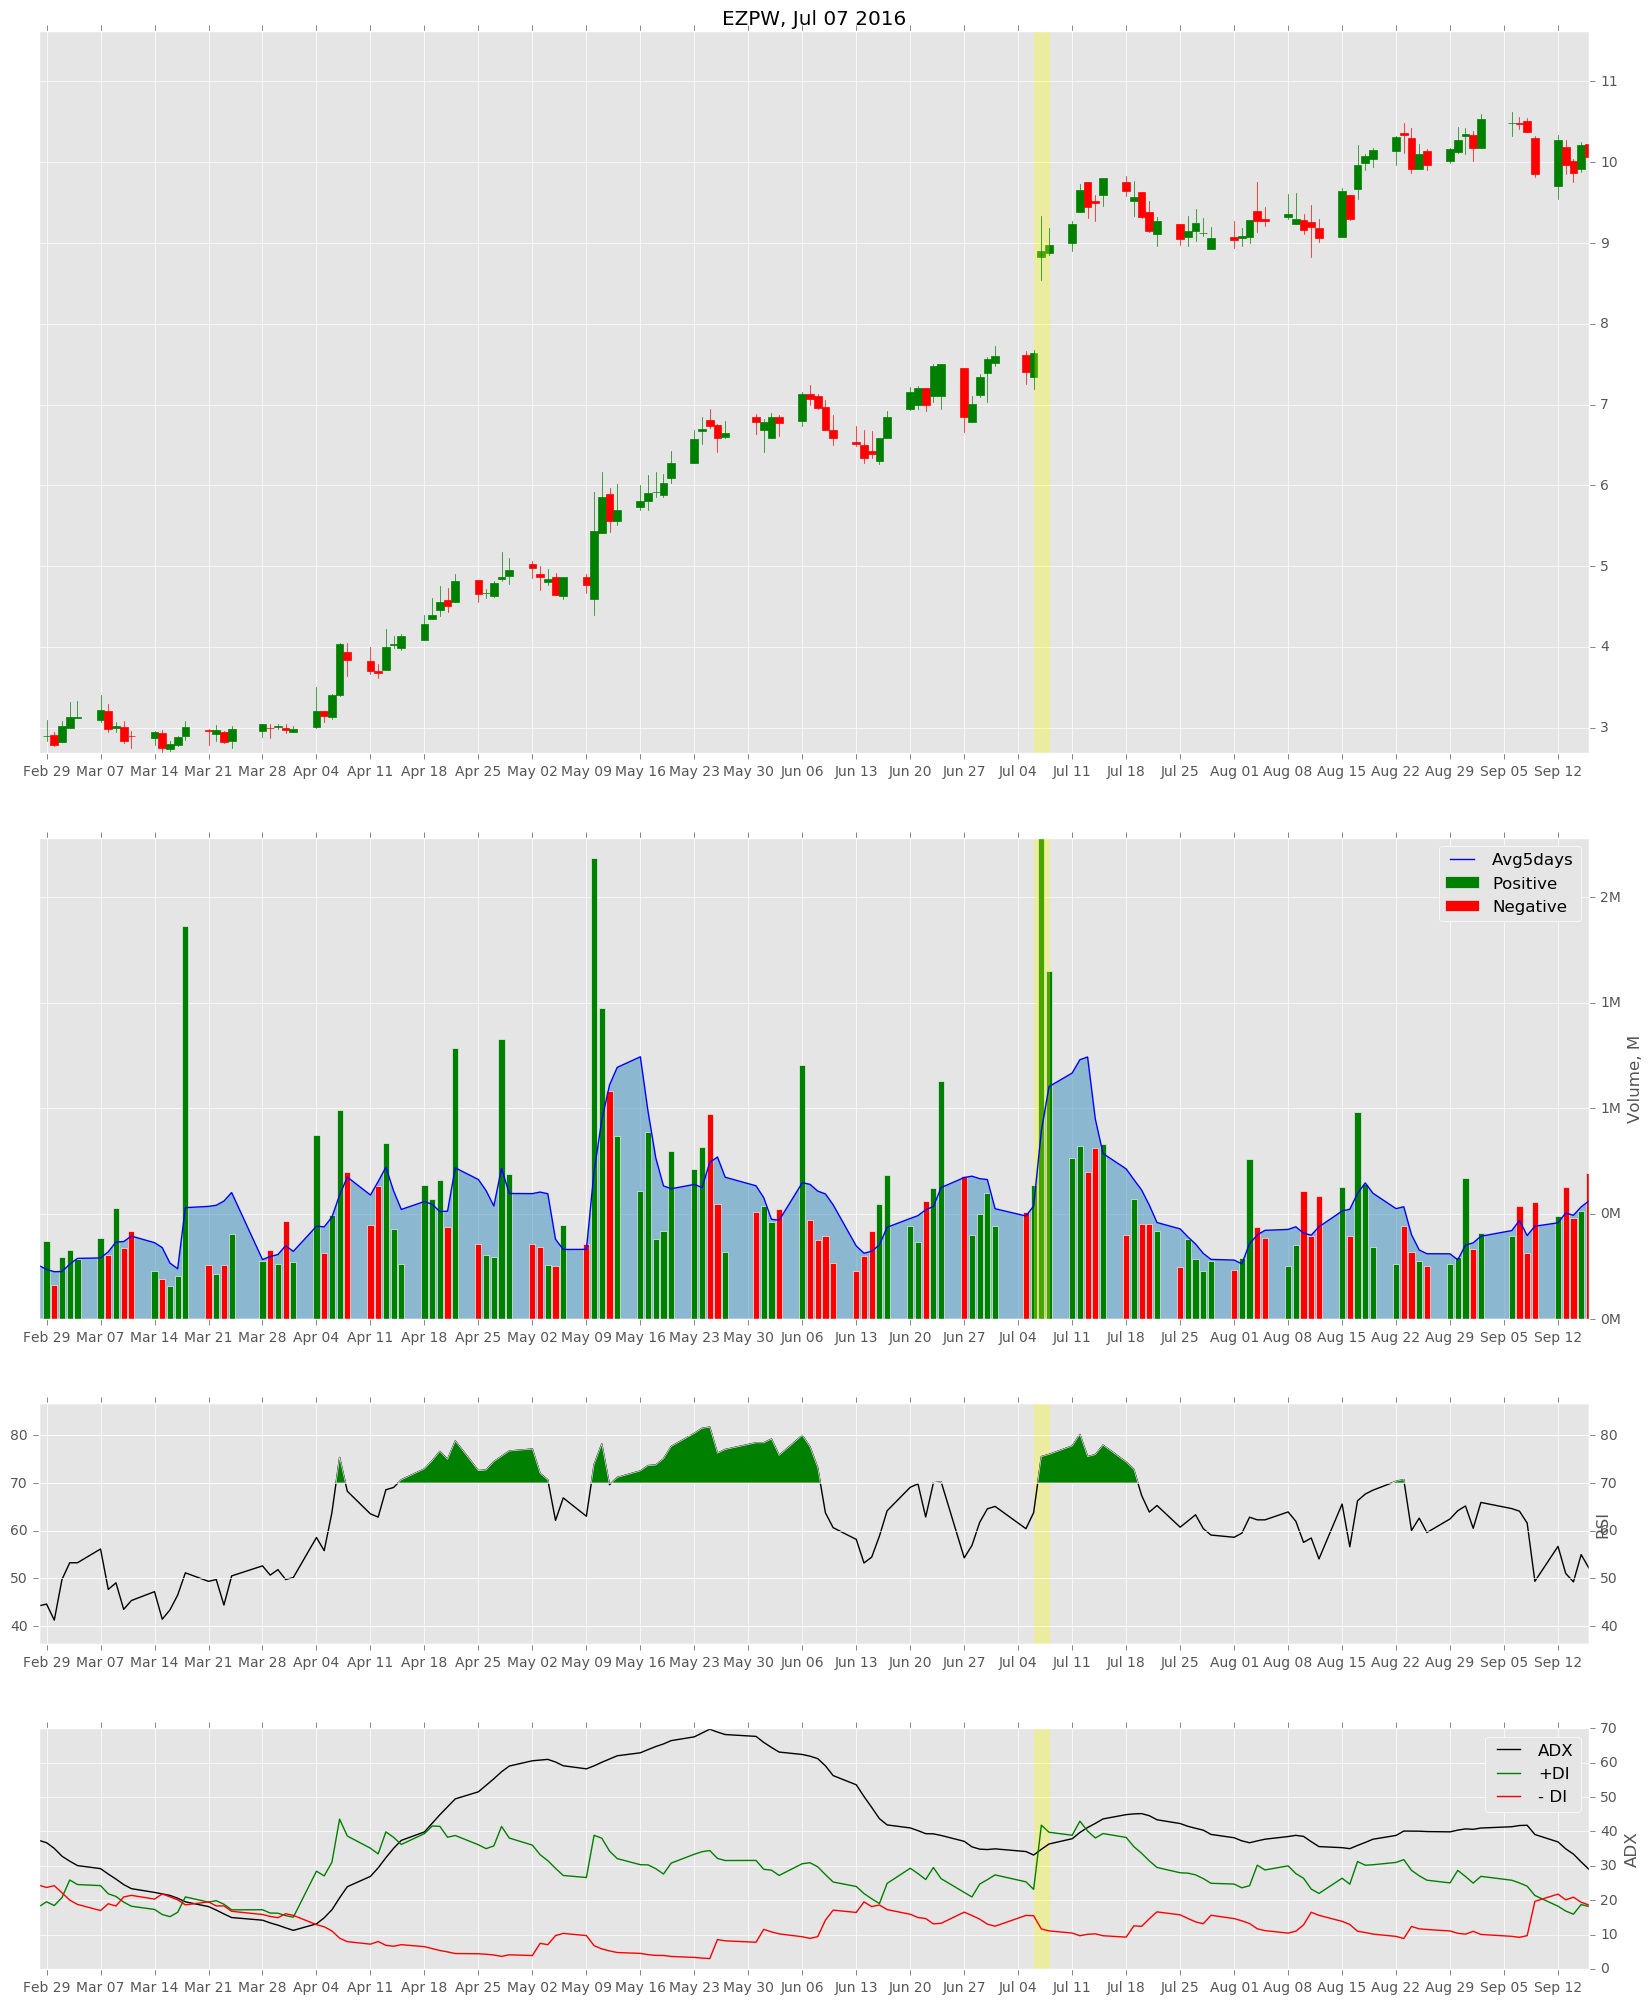

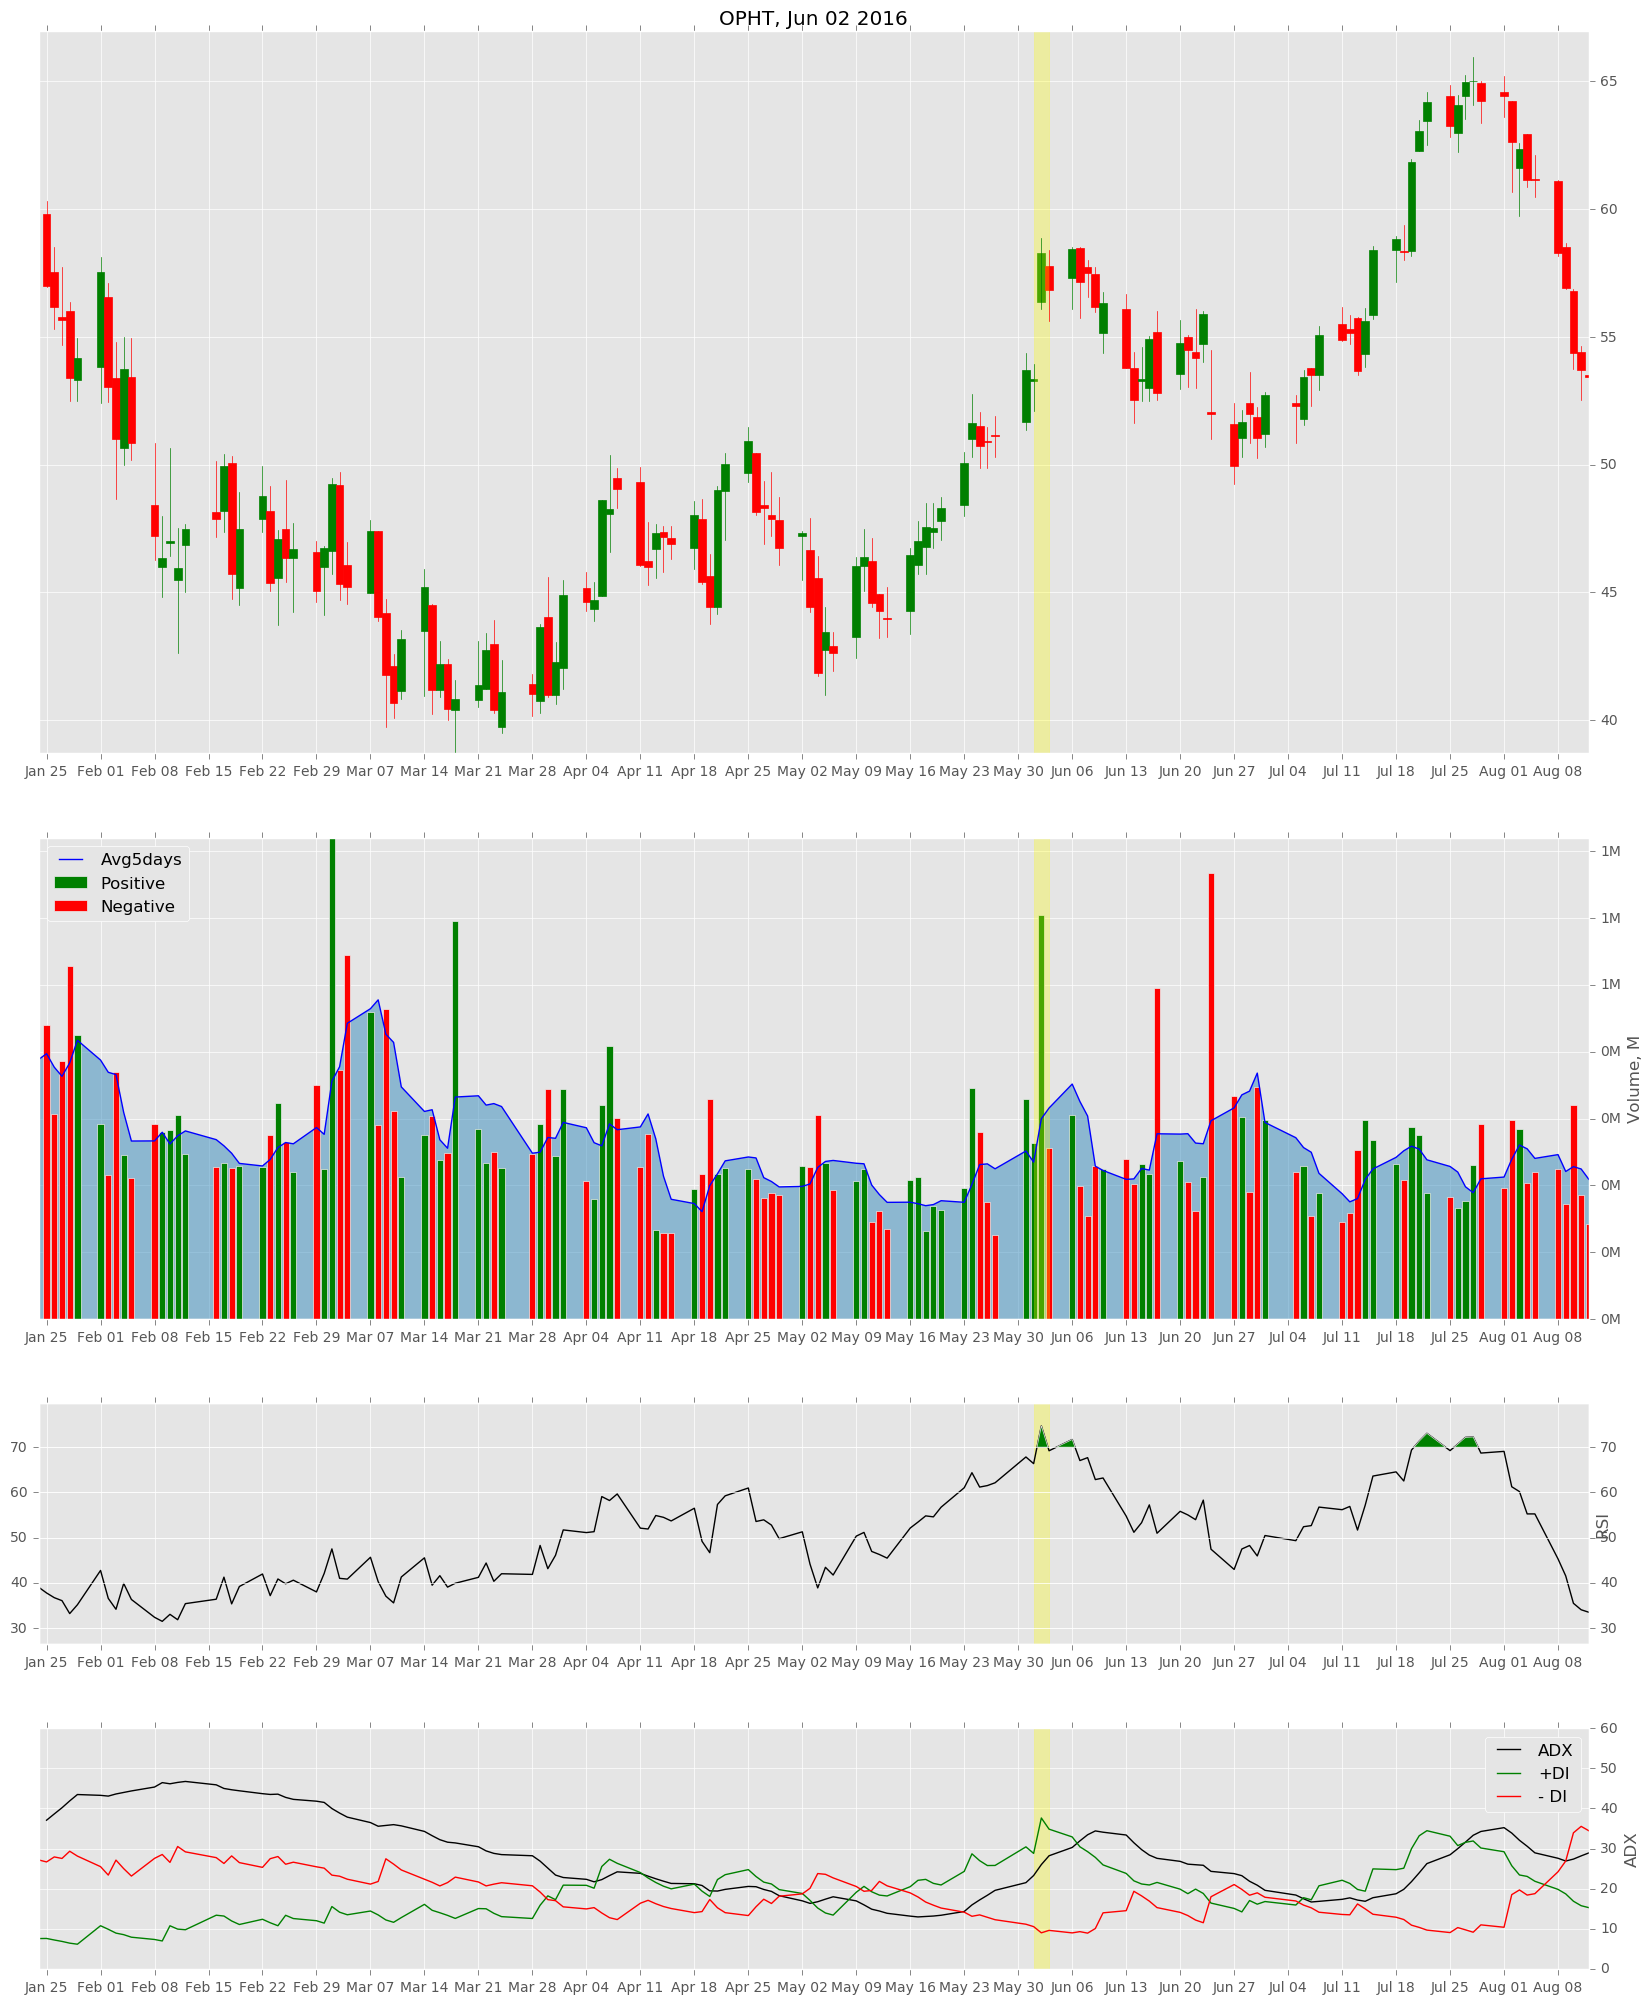

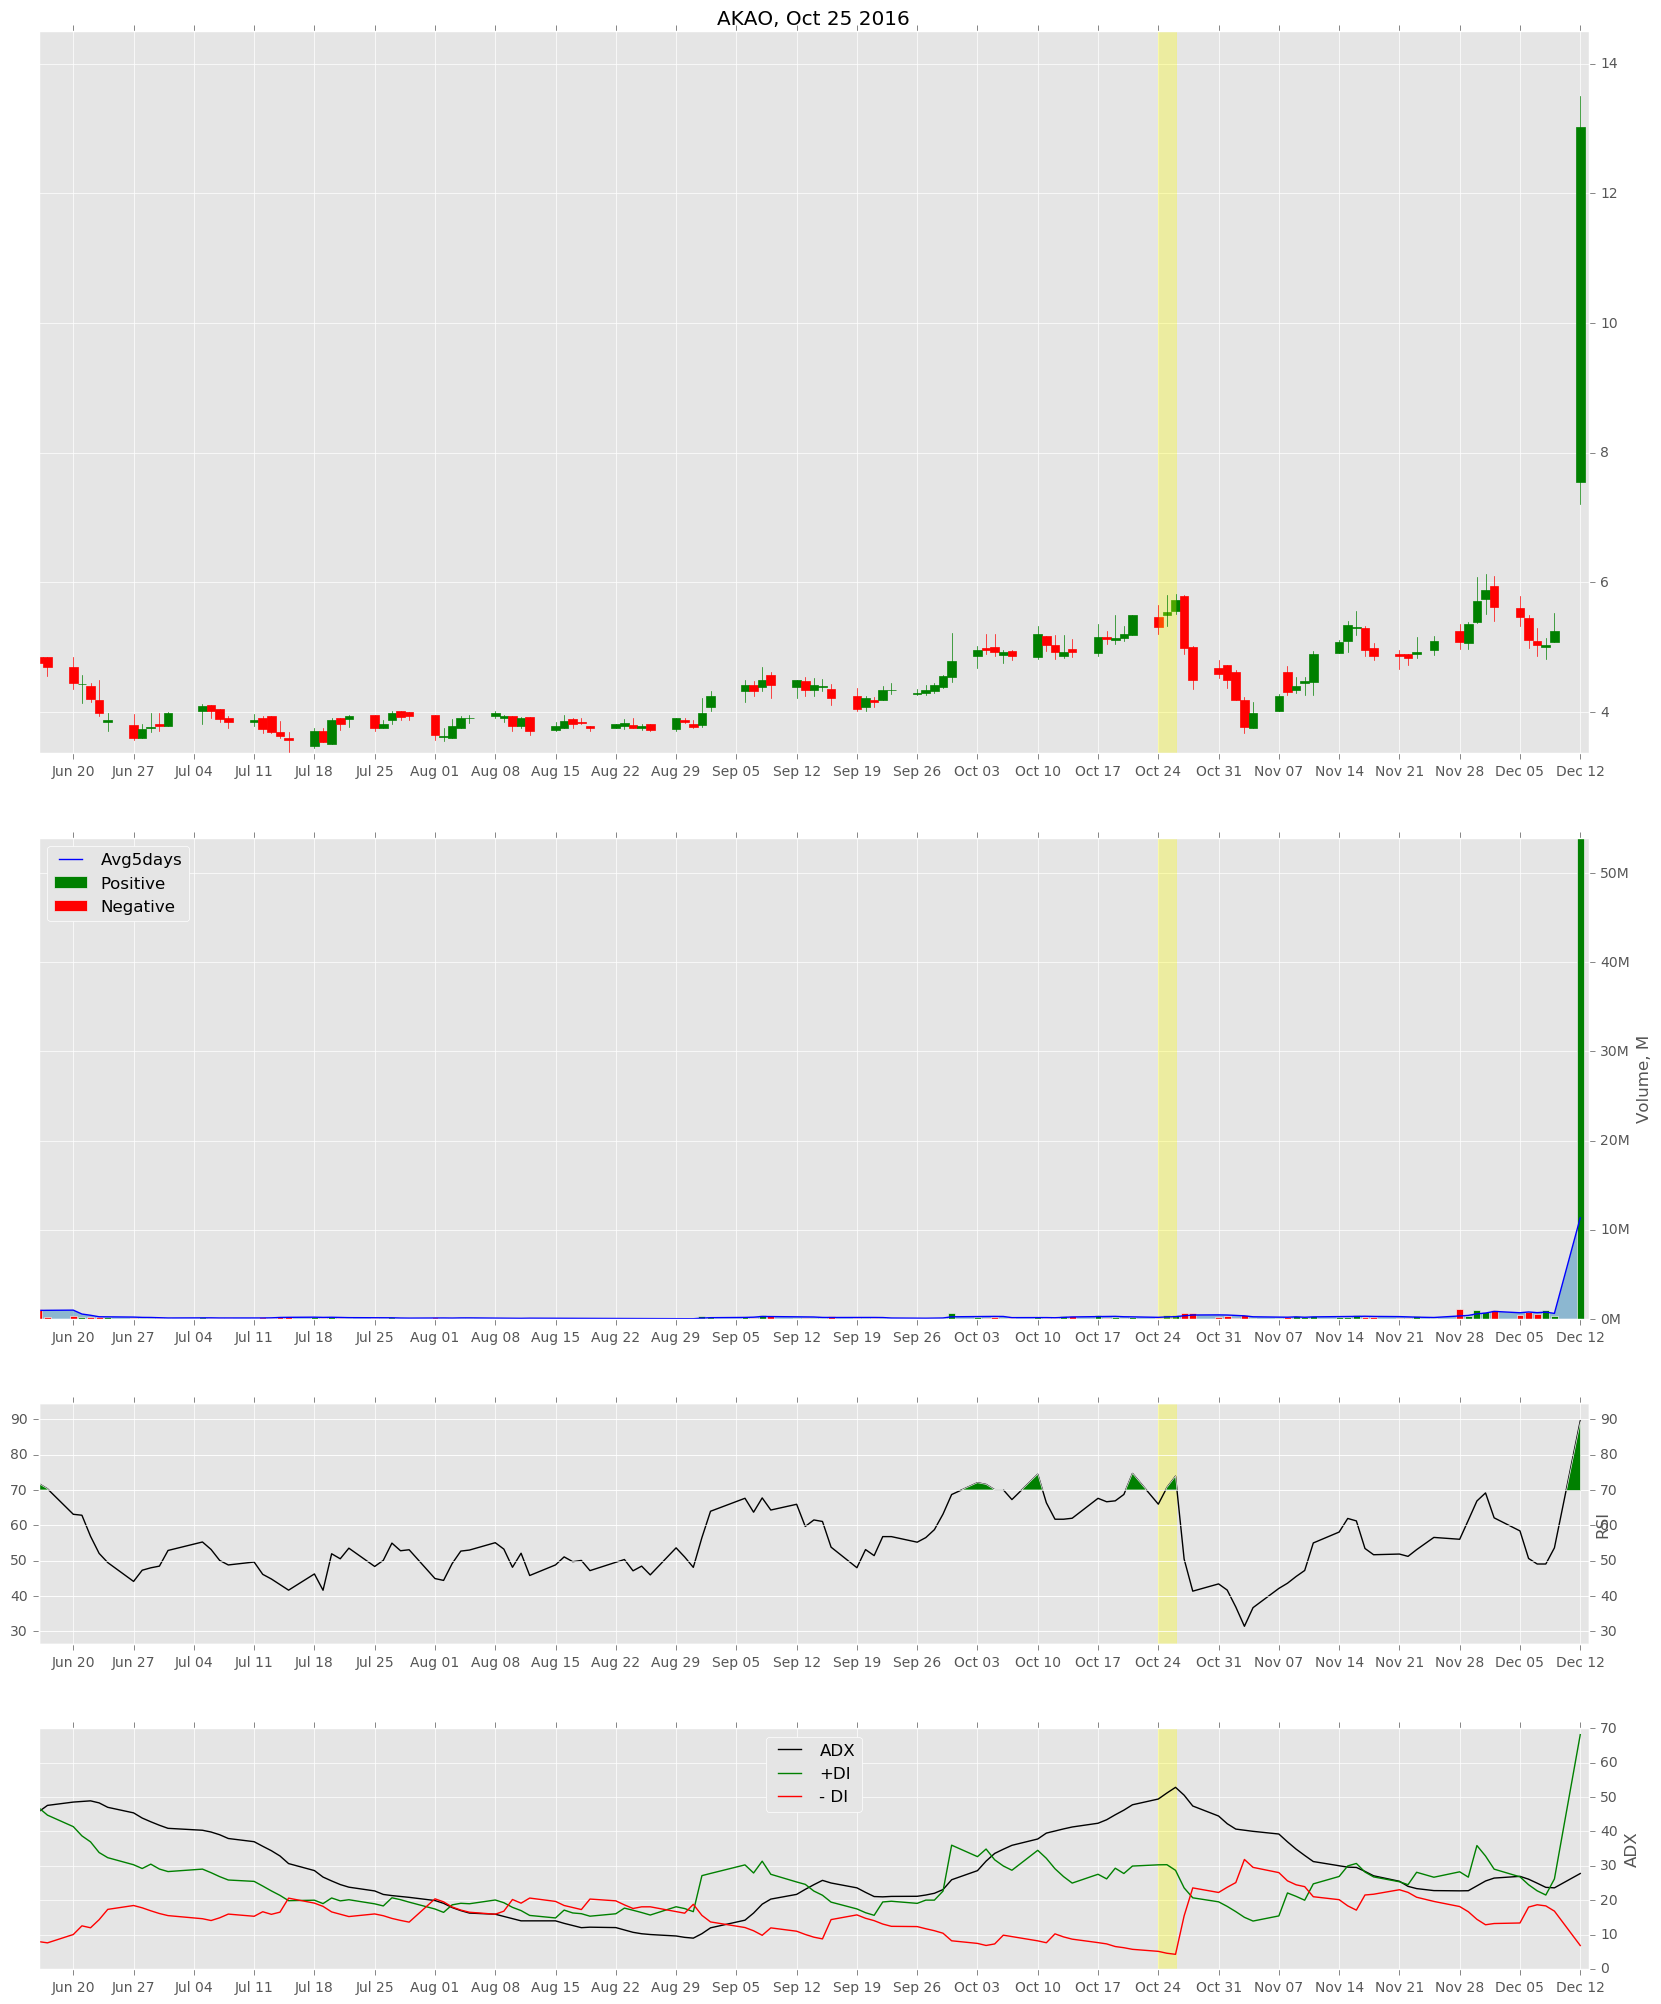

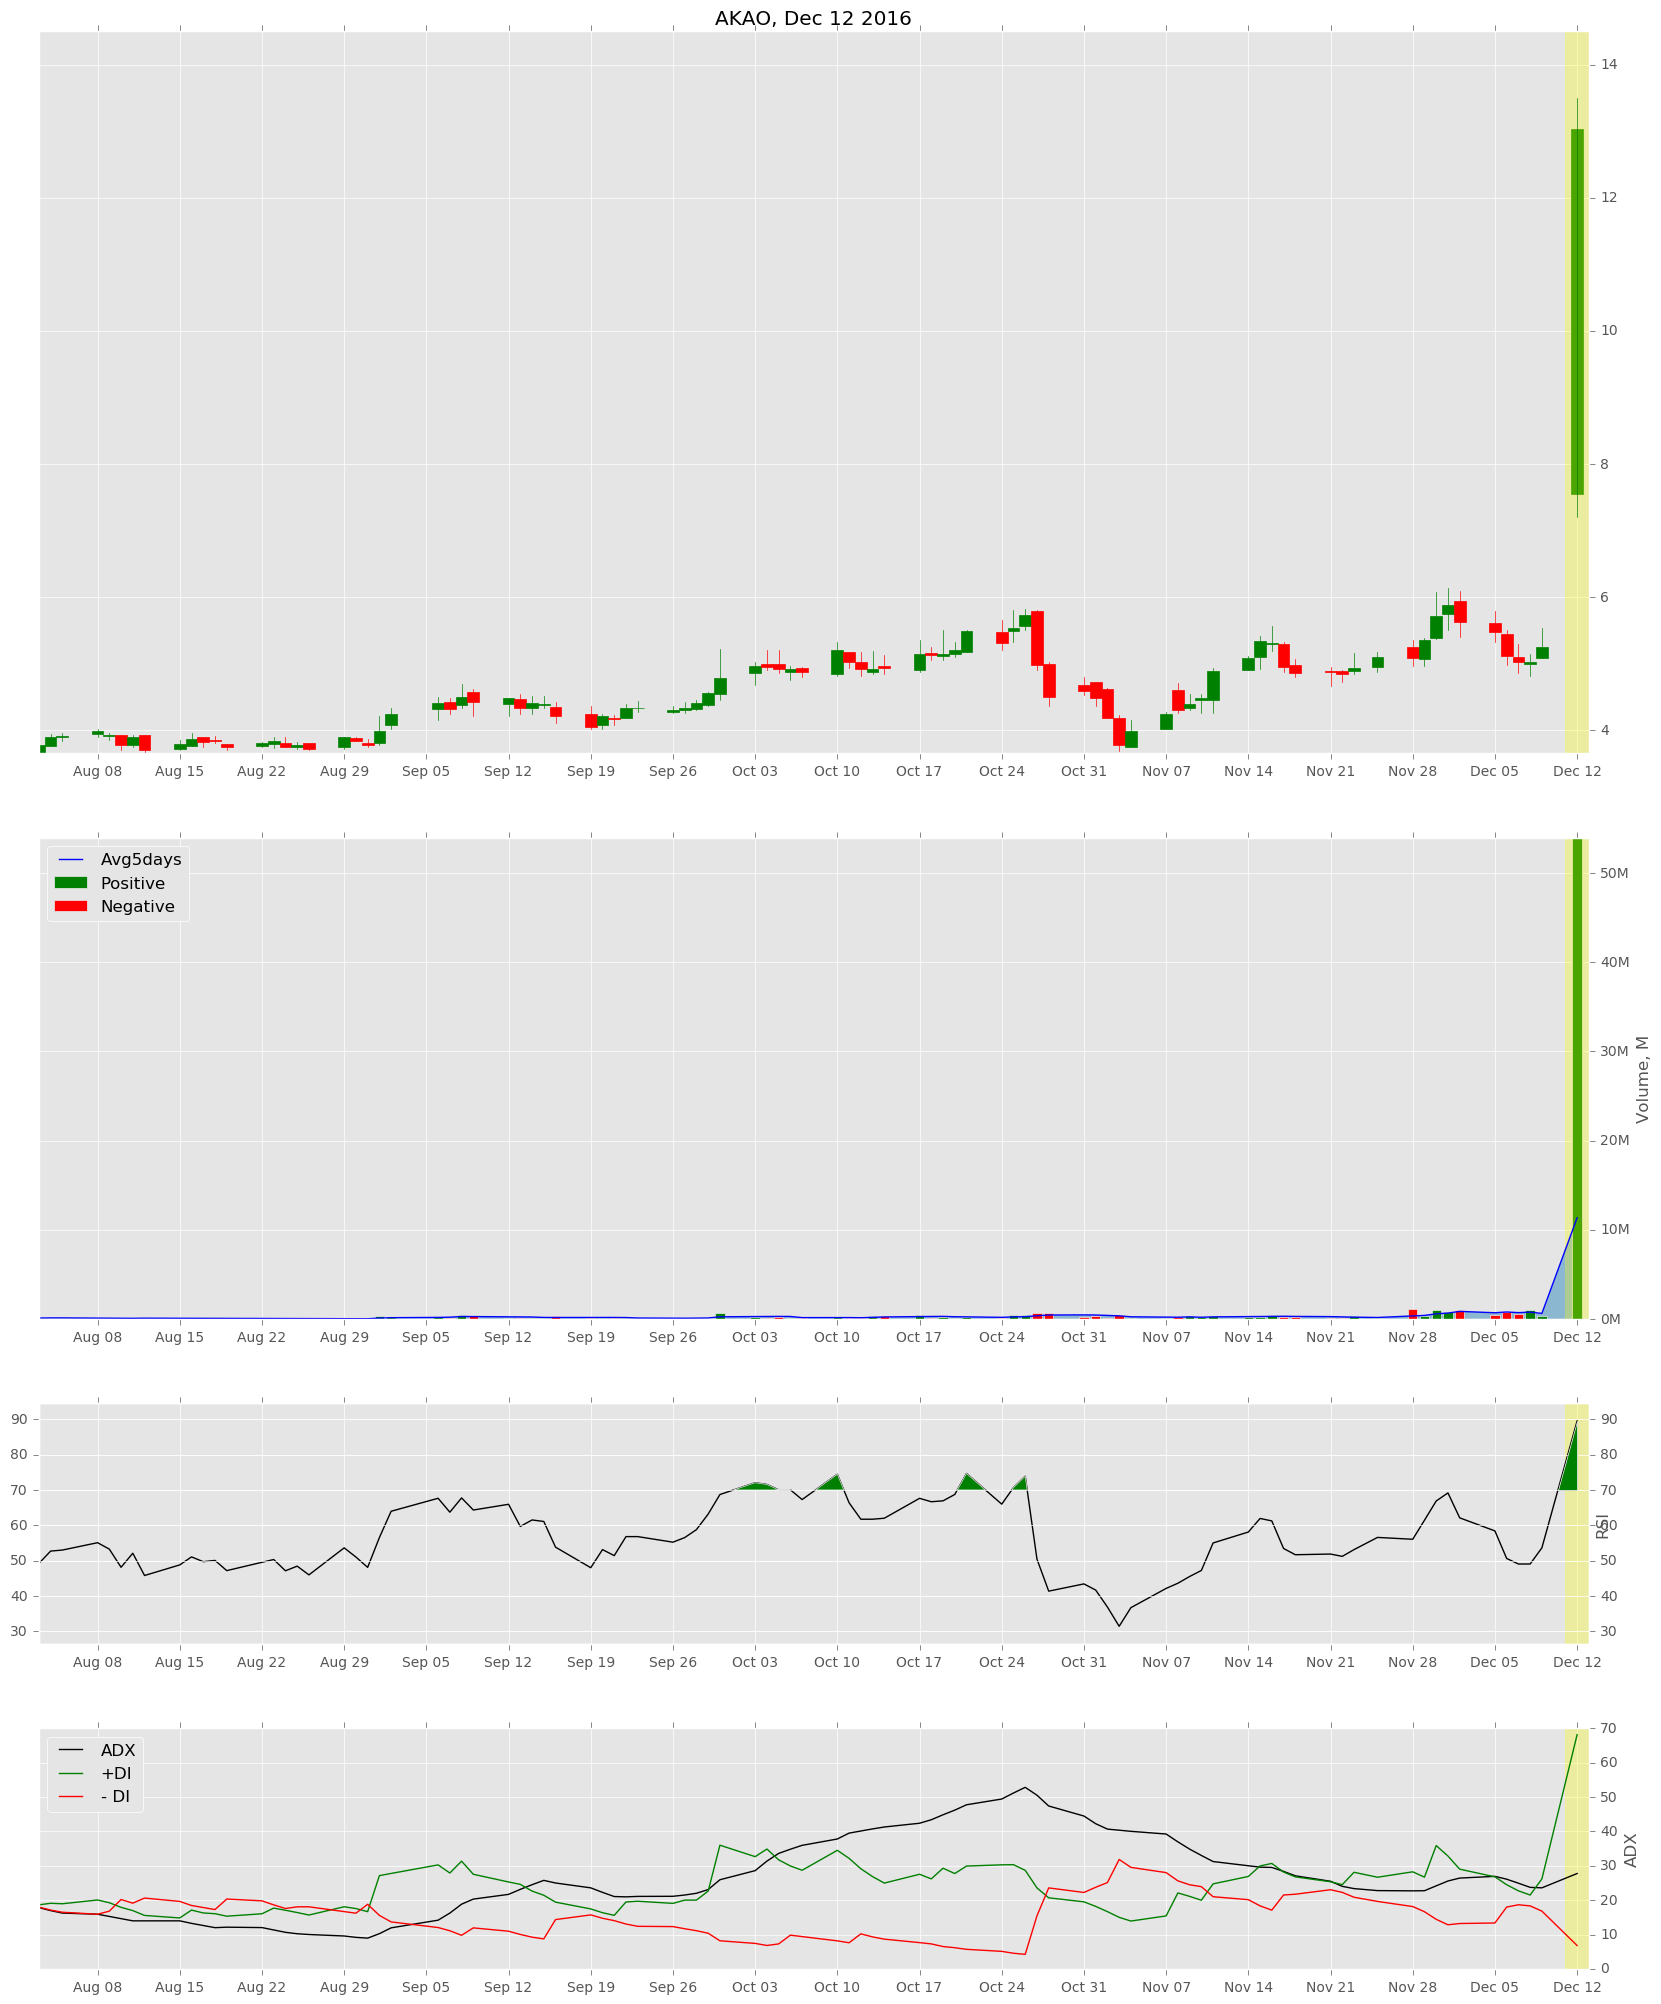

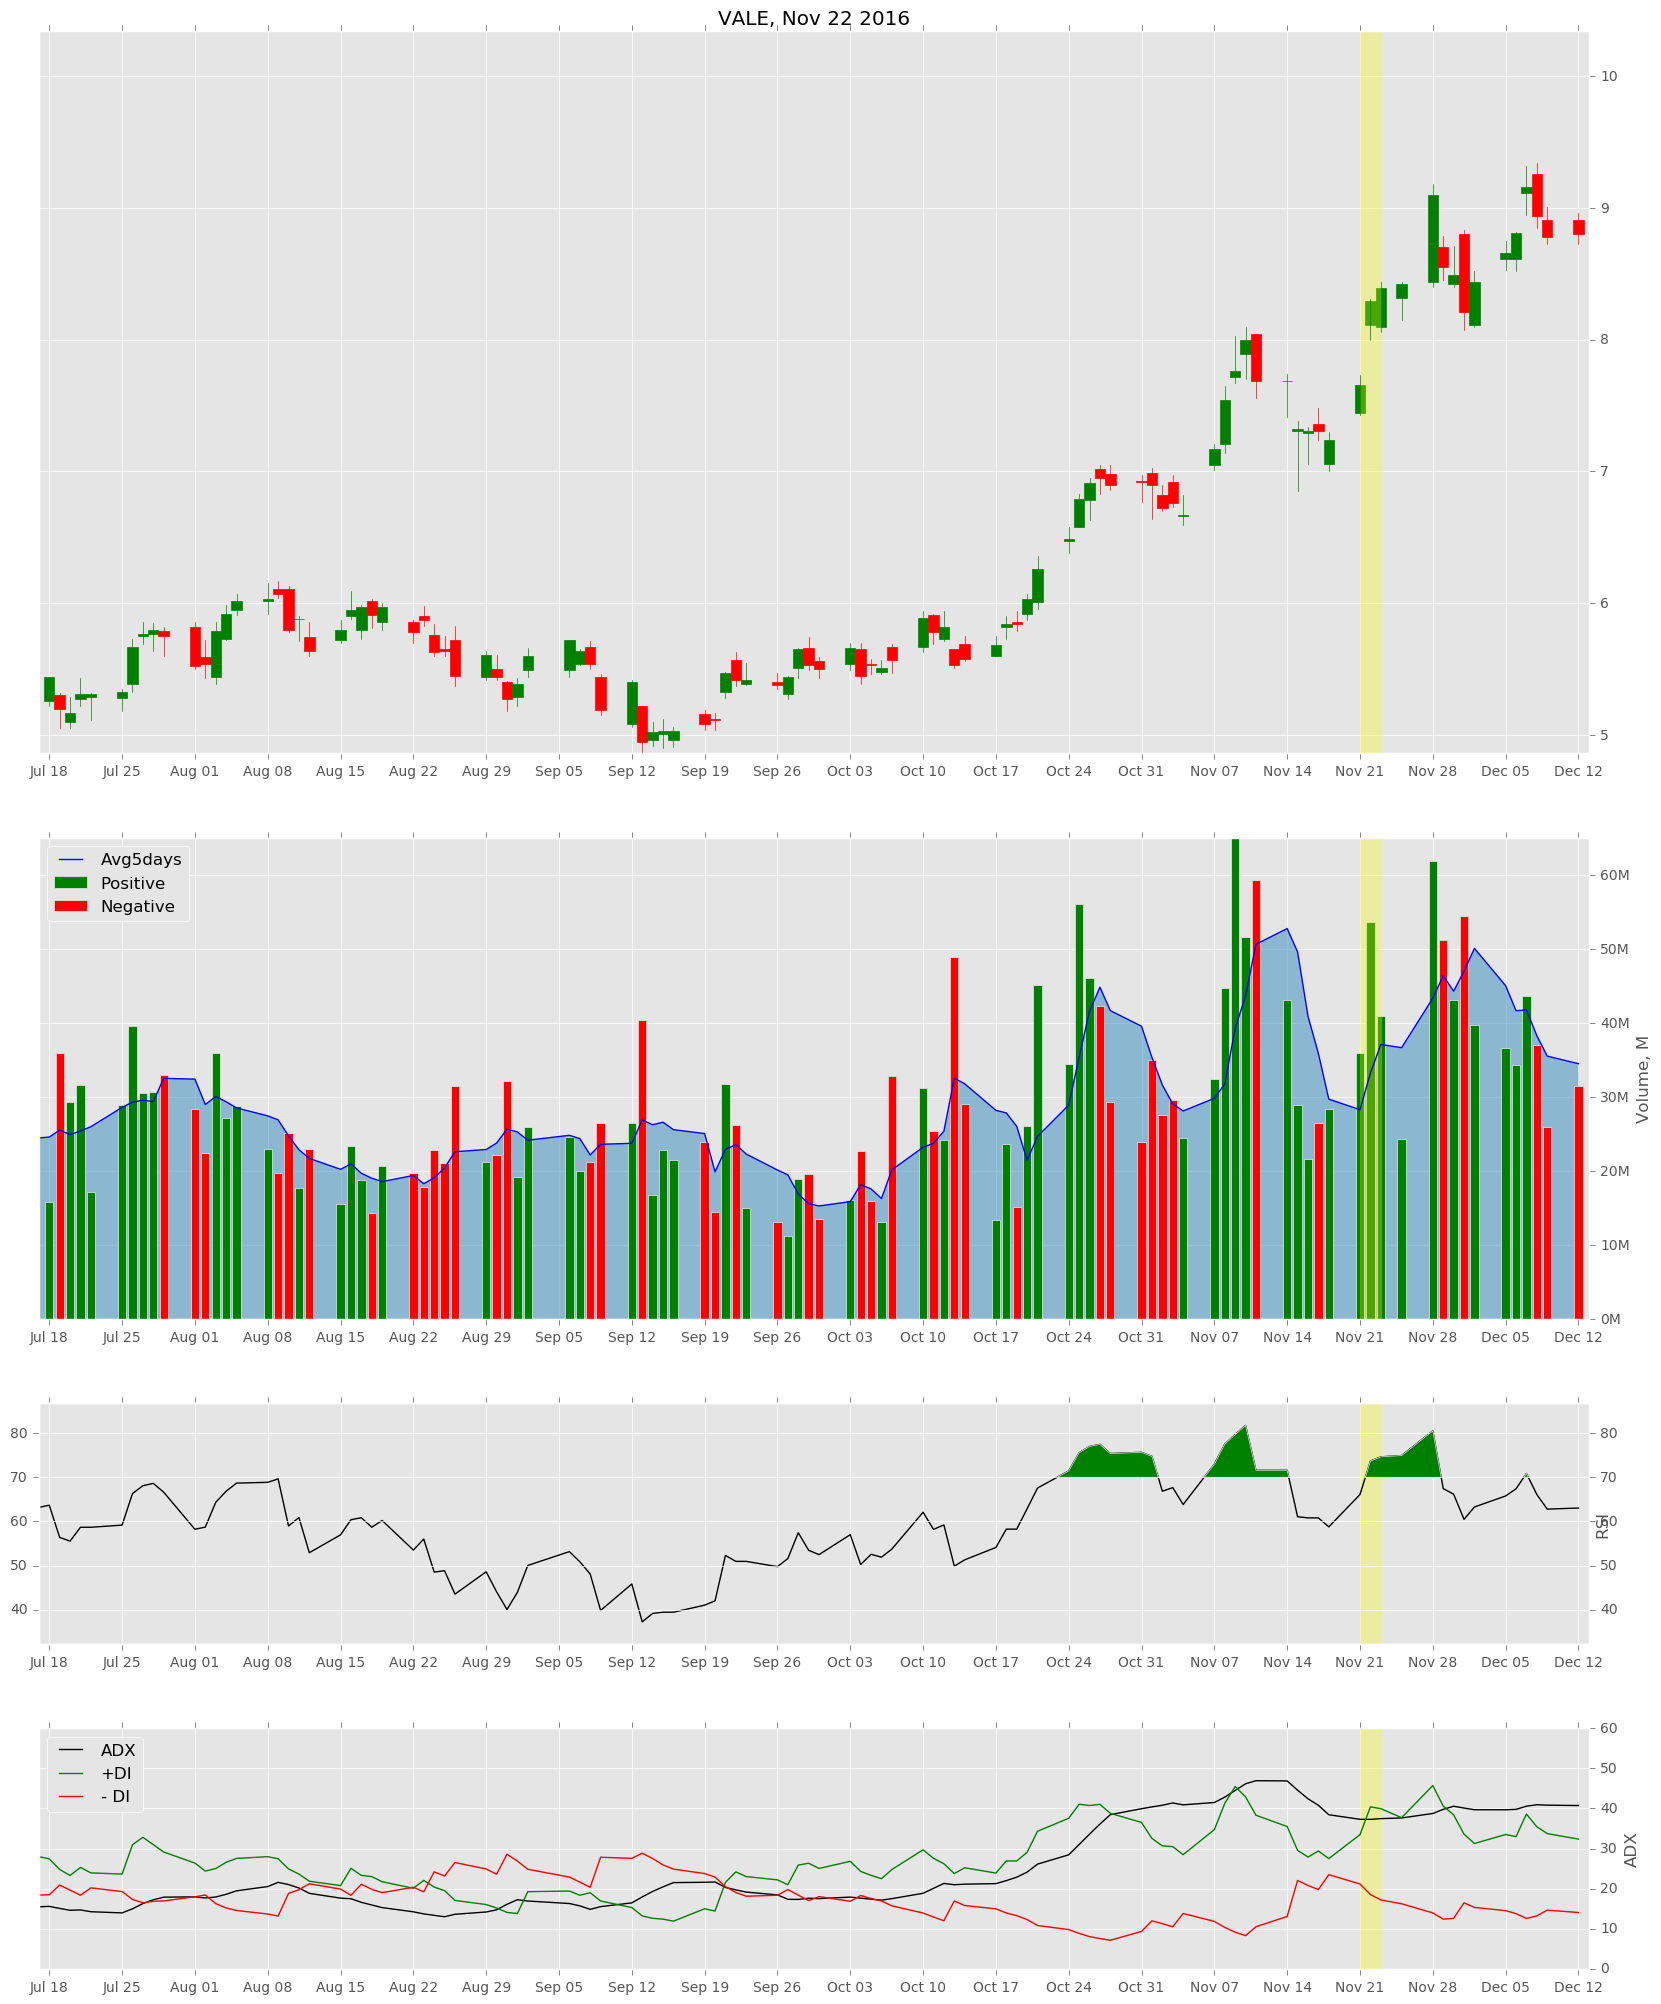

In [17]:
stocks = ('AMD', 'BAC', 'FB', 'GOOG', 'EZPW', 'OPHT', 'AKAO', 'VALE')

instances = []
for key in stocks:
    data = get_data(key)
    key_instances = get_pattern_instances(data)
    
    for instance in key_instances:        
        
        # now lets get the next 50 day data from this date
        gap_index = data.index.get_loc(instance)
        window = data[gap_index:gap_index + 50]
        
        if len(window) < 50:
            print('Warning: There are only {} days after {}'.format(len(window), instance.date()))
        
        # and calculate returns
        first_day_open = data.iat[gap_index, 0]
        returns = (window.Close / first_day_open - 1) * 100
        returns.name = "{}, {:%b %d %Y}".format(key, instance.date())
        # draw plot
        plot_data(returns.name, data, instance, show=False)
        
        returns.index = range(len(returns))
        instances.append(returns)

print("\nFound total of %d instances" % len(instances))
plt.show()

In [18]:
# merge all returns into one dataframe
result = pd.concat(instances, axis=1)
result

AMD, Apr 22 2016  AMD, Dec 06 2016  AMD, Dec 08 2016  BAC, Nov 09 2016  \
0          25.078370          5.586592          4.444444          1.755374   
1           8.150470          6.815642          4.444444          6.228766   
2          14.733542         15.530726          7.878788          7.701019   
3          16.927900         15.530726               NaN         13.703284   
4          13.166144         19.329609               NaN         14.156285   
5          11.285266               NaN               NaN         11.834655   
6          17.241379               NaN               NaN         13.703284   
7          12.852665               NaN               NaN         13.250283   
8          12.852665               NaN               NaN         15.118913   
9          14.733542               NaN               NaN         14.949032   
10         15.360502               NaN               NaN         16.421285   
11         14.420063               NaN               NaN         18.120051   
12         14.106583               NaN               NaN         14.949032   
13         14.420063               NaN               NaN         14.892418   
14         12.539185               NaN               NaN         19.592305   
15         15.047022               NaN               NaN         21.744054   
16         18.808777               NaN               NaN         20.215176   
17         18.808777               NaN               NaN         23.669309   
18         20.376176               NaN               NaN         25.481314   
19         18.181818               NaN               NaN         27.802945   
20         21.316614               NaN               NaN         29.954706   
21         26.645768               NaN               NaN         30.747452   
22         31.661442               NaN               NaN         28.029451   
23         31.034483               NaN               NaN               NaN   
24         36.363636               NaN               NaN               NaN   
25         44.200627               NaN               NaN               NaN   
26         43.260188               NaN               NaN               NaN   
27         38.871473               NaN               NaN               NaN   
28         32.915361               NaN               NaN               NaN   
29         30.407524               NaN               NaN               NaN   
30         40.125392               NaN               NaN               NaN   
31         41.379310               NaN               NaN               NaN   
32         39.811912               NaN               NaN               NaN   
33         41.692790               NaN               NaN               NaN   
34         35.423197               NaN               NaN               NaN   
35         37.931034               NaN               NaN               NaN   
36         37.617555               NaN               NaN               NaN   
37         38.557994               NaN               NaN               NaN   
38         48.902821               NaN               NaN               NaN   
39         64.890282               NaN               NaN               NaN   
40         59.874608               NaN               NaN               NaN   
41         70.846395               NaN               NaN               NaN   
42         57.366771               NaN               NaN               NaN   
43         63.322884               NaN               NaN               NaN   
44         52.978056               NaN               NaN               NaN   
45         47.962382               NaN               NaN               NaN   
46         60.501567               NaN               NaN               NaN   
47         60.815047               NaN               NaN               NaN   
48         61.128527               NaN               NaN               NaN   
49         58.934169               NaN               NaN               NaN   

    FB, Jul 28 2016  GOOG

### PATTERN MEASURING

#### Measuring criteria:

- Enter into the trade during the next day’s Open Price
- Measure trade’s performance each of 49 trading days based on the close prices for each of the pattern instances (and average it)
- Calculate win and loss rates for each of 49 trading days on the close prices  for each of the pattern instances (and average it)
- Develop charts using matplotlib

In [19]:
columns = list(result.columns)
result['NegativeCount'] = sum(result[key] < 0 for key in columns)
result['PositiveCount'] = sum(result[key] > 0 for key in columns)

def avg_positive(df):
    pos_values = np.array([df[k] for k in columns if df[k] > 0])
    if len(pos_values):
        return np.average(pos_values)
    else:
        return 0
    
result['AvgPositive'] = result.apply(avg_positive, axis=1)
result

AMD, Apr 22 2016  AMD, Dec 06 2016  AMD, Dec 08 2016  BAC, Nov 09 2016  \
0          25.078370          5.586592          4.444444          1.755374   
1           8.150470          6.815642          4.444444          6.228766   
2          14.733542         15.530726          7.878788          7.701019   
3          16.927900         15.530726               NaN         13.703284   
4          13.166144         19.329609               NaN         14.156285   
5          11.285266               NaN               NaN         11.834655   
6          17.241379               NaN               NaN         13.703284   
7          12.852665               NaN               NaN         13.250283   
8          12.852665               NaN               NaN         15.118913   
9          14.733542               NaN               NaN         14.949032   
10         15.360502               NaN               NaN         16.421285   
11         14.420063               NaN               NaN         18.120051   
12         14.106583               NaN               NaN         14.949032   
13         14.420063               NaN               NaN         14.892418   
14         12.539185               NaN               NaN         19.592305   
15         15.047022               NaN               NaN         21.744054   
16         18.808777               NaN               NaN         20.215176   
17         18.808777               NaN               NaN         23.669309   
18         20.376176               NaN               NaN         25.481314   
19         18.181818               NaN               NaN         27.802945   
20         21.316614               NaN               NaN         29.954706   
21         26.645768               NaN               NaN         30.747452   
22         31.661442               NaN               NaN         28.029451   
23         31.034483               NaN               NaN               NaN   
24         36.363636               NaN               NaN               NaN   
25         44.200627               NaN               NaN               NaN   
26         43.260188               NaN               NaN               NaN   
27         38.871473               NaN               NaN               NaN   
28         32.915361               NaN               NaN               NaN   
29         30.407524               NaN               NaN               NaN   
30         40.125392               NaN               NaN               NaN   
31         41.379310               NaN               NaN               NaN   
32         39.811912               NaN               NaN               NaN   
33         41.692790               NaN               NaN               NaN   
34         35.423197               NaN               NaN               NaN   
35         37.931034               NaN               NaN               NaN   
36         37.617555               NaN               NaN               NaN   
37         38.557994               NaN               NaN               NaN   
38         48.902821               NaN               NaN               NaN   
39         64.890282               NaN               NaN               NaN   
40         59.874608               NaN               NaN               NaN   
41         70.846395               NaN               NaN               NaN   
42         57.366771               NaN               NaN               NaN   
43         63.322884               NaN               NaN               NaN   
44         52.978056               NaN               NaN               NaN   
45         47.962382               NaN               NaN               NaN   
46         60.501567               NaN               NaN               NaN   
47         60.815047               NaN               NaN               NaN   
48         61.128527               NaN               NaN               NaN   
49         58.934169               NaN               NaN               NaN   

    FB, Jul 28 2016  GOOG

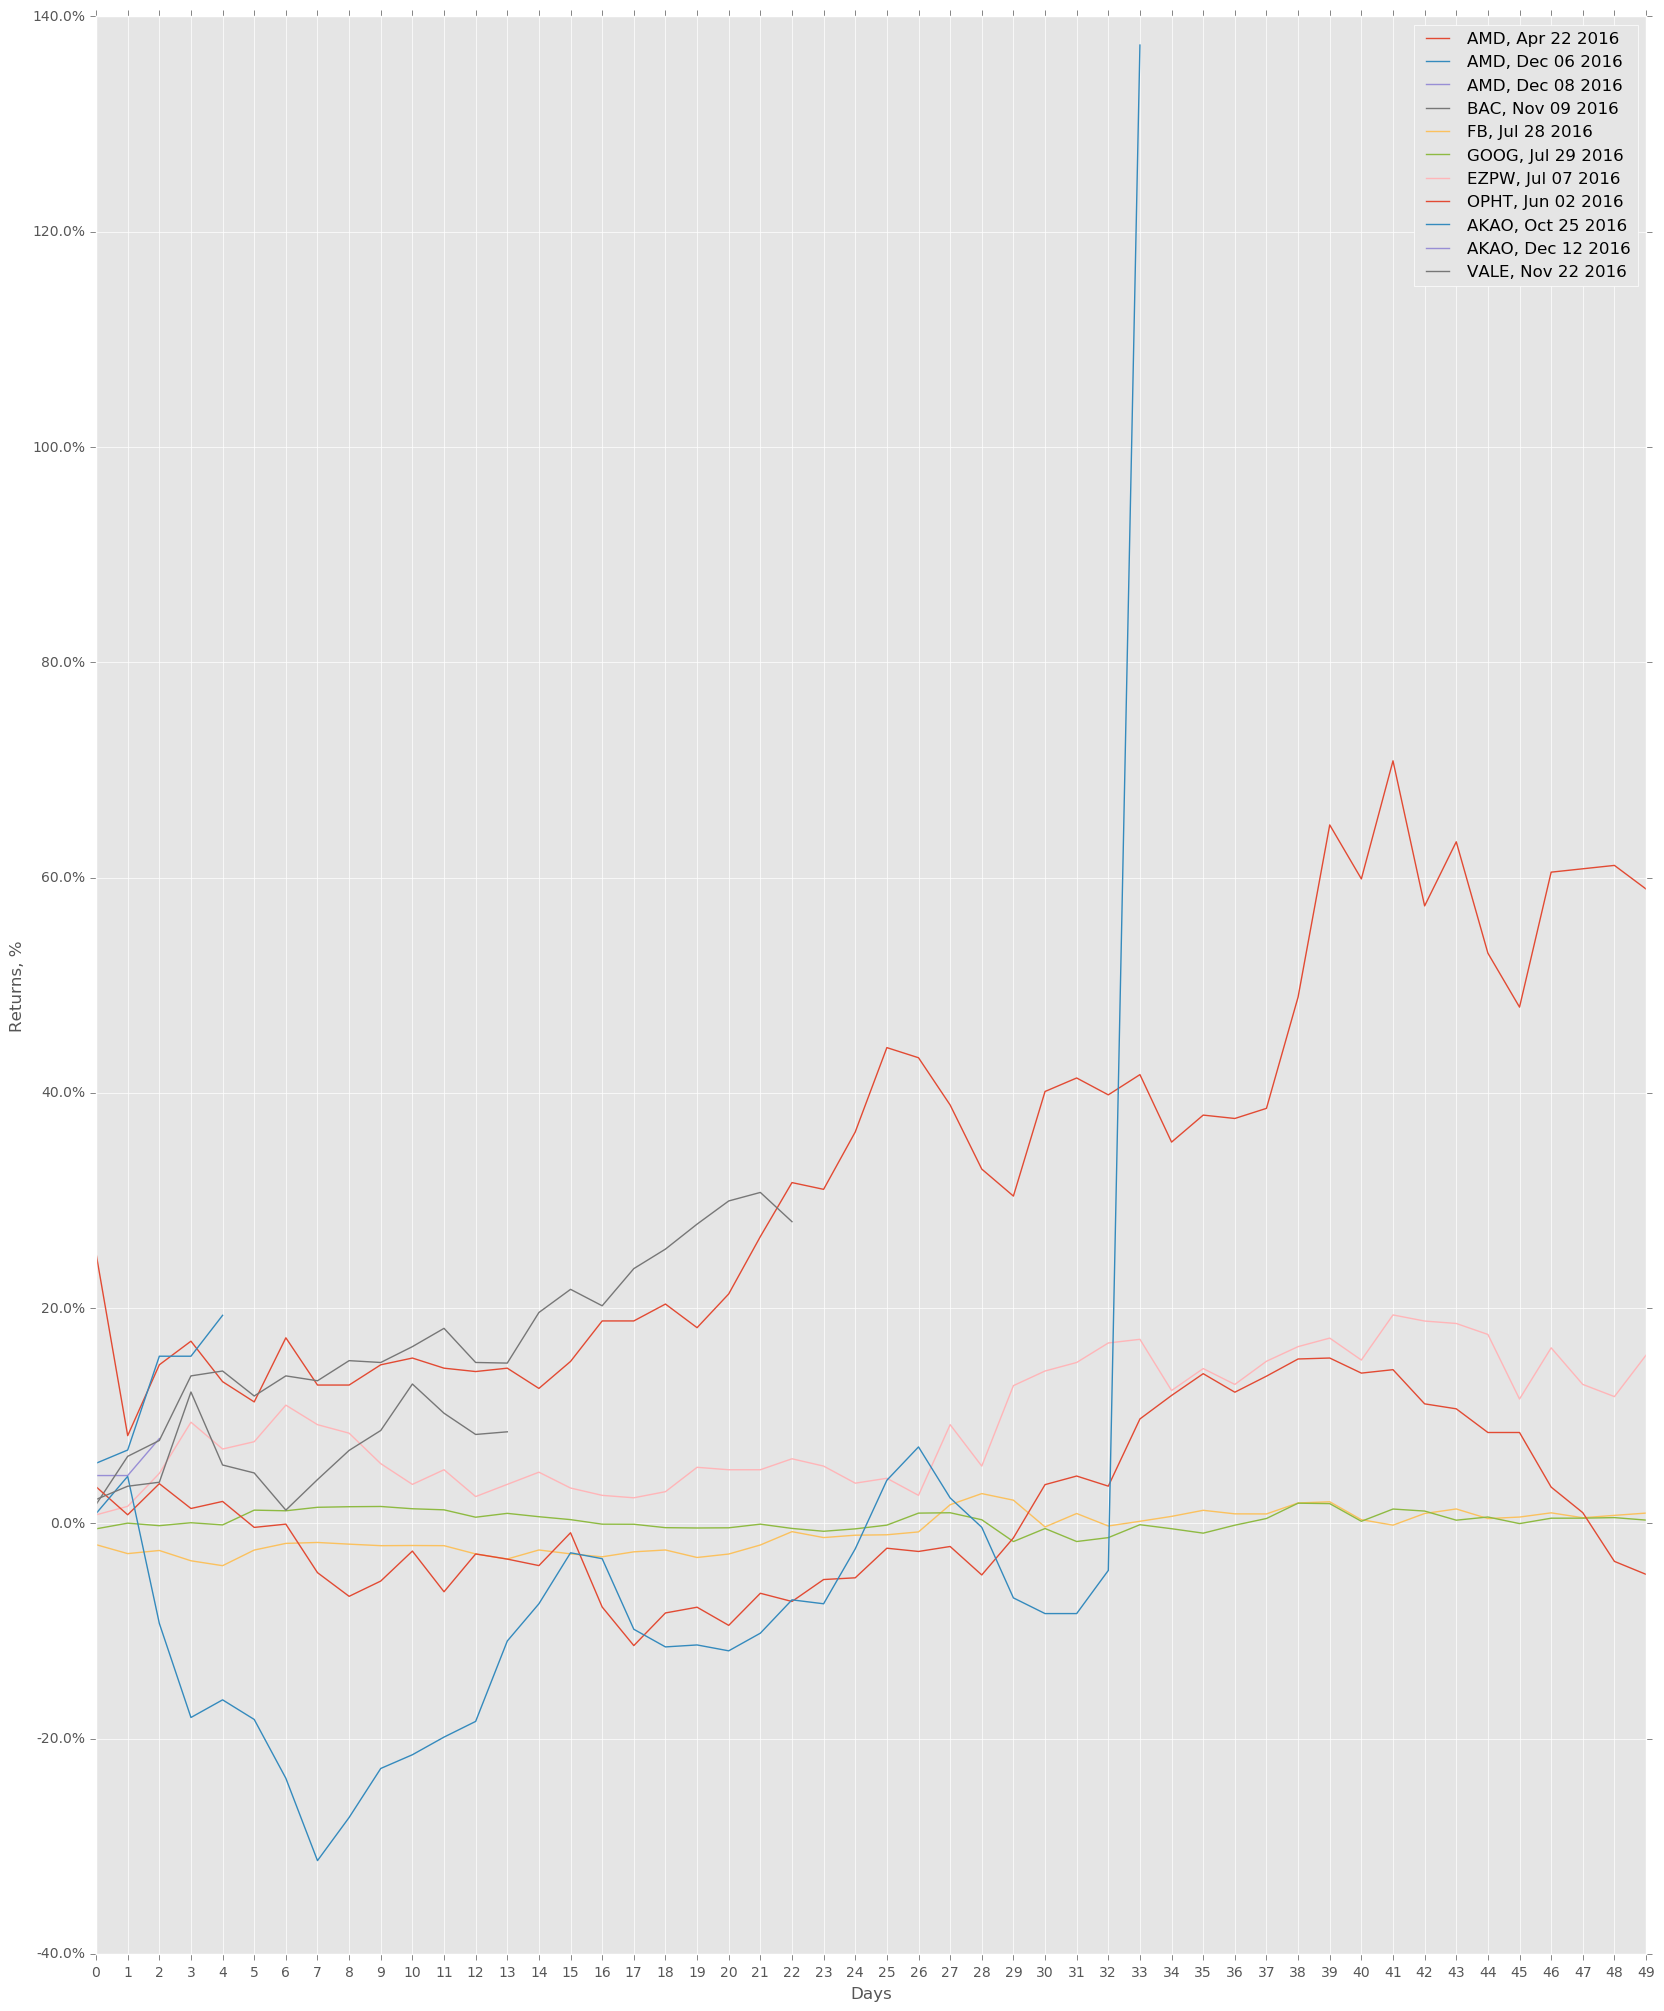

In [20]:
fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(111)

result[columns].plot(ax=ax, xticks=range(0, 50))

ax.set_xlabel('Days')
ax.set_ylabel('Returns, %')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x,p: "{}%".format(x)))
plt.show()

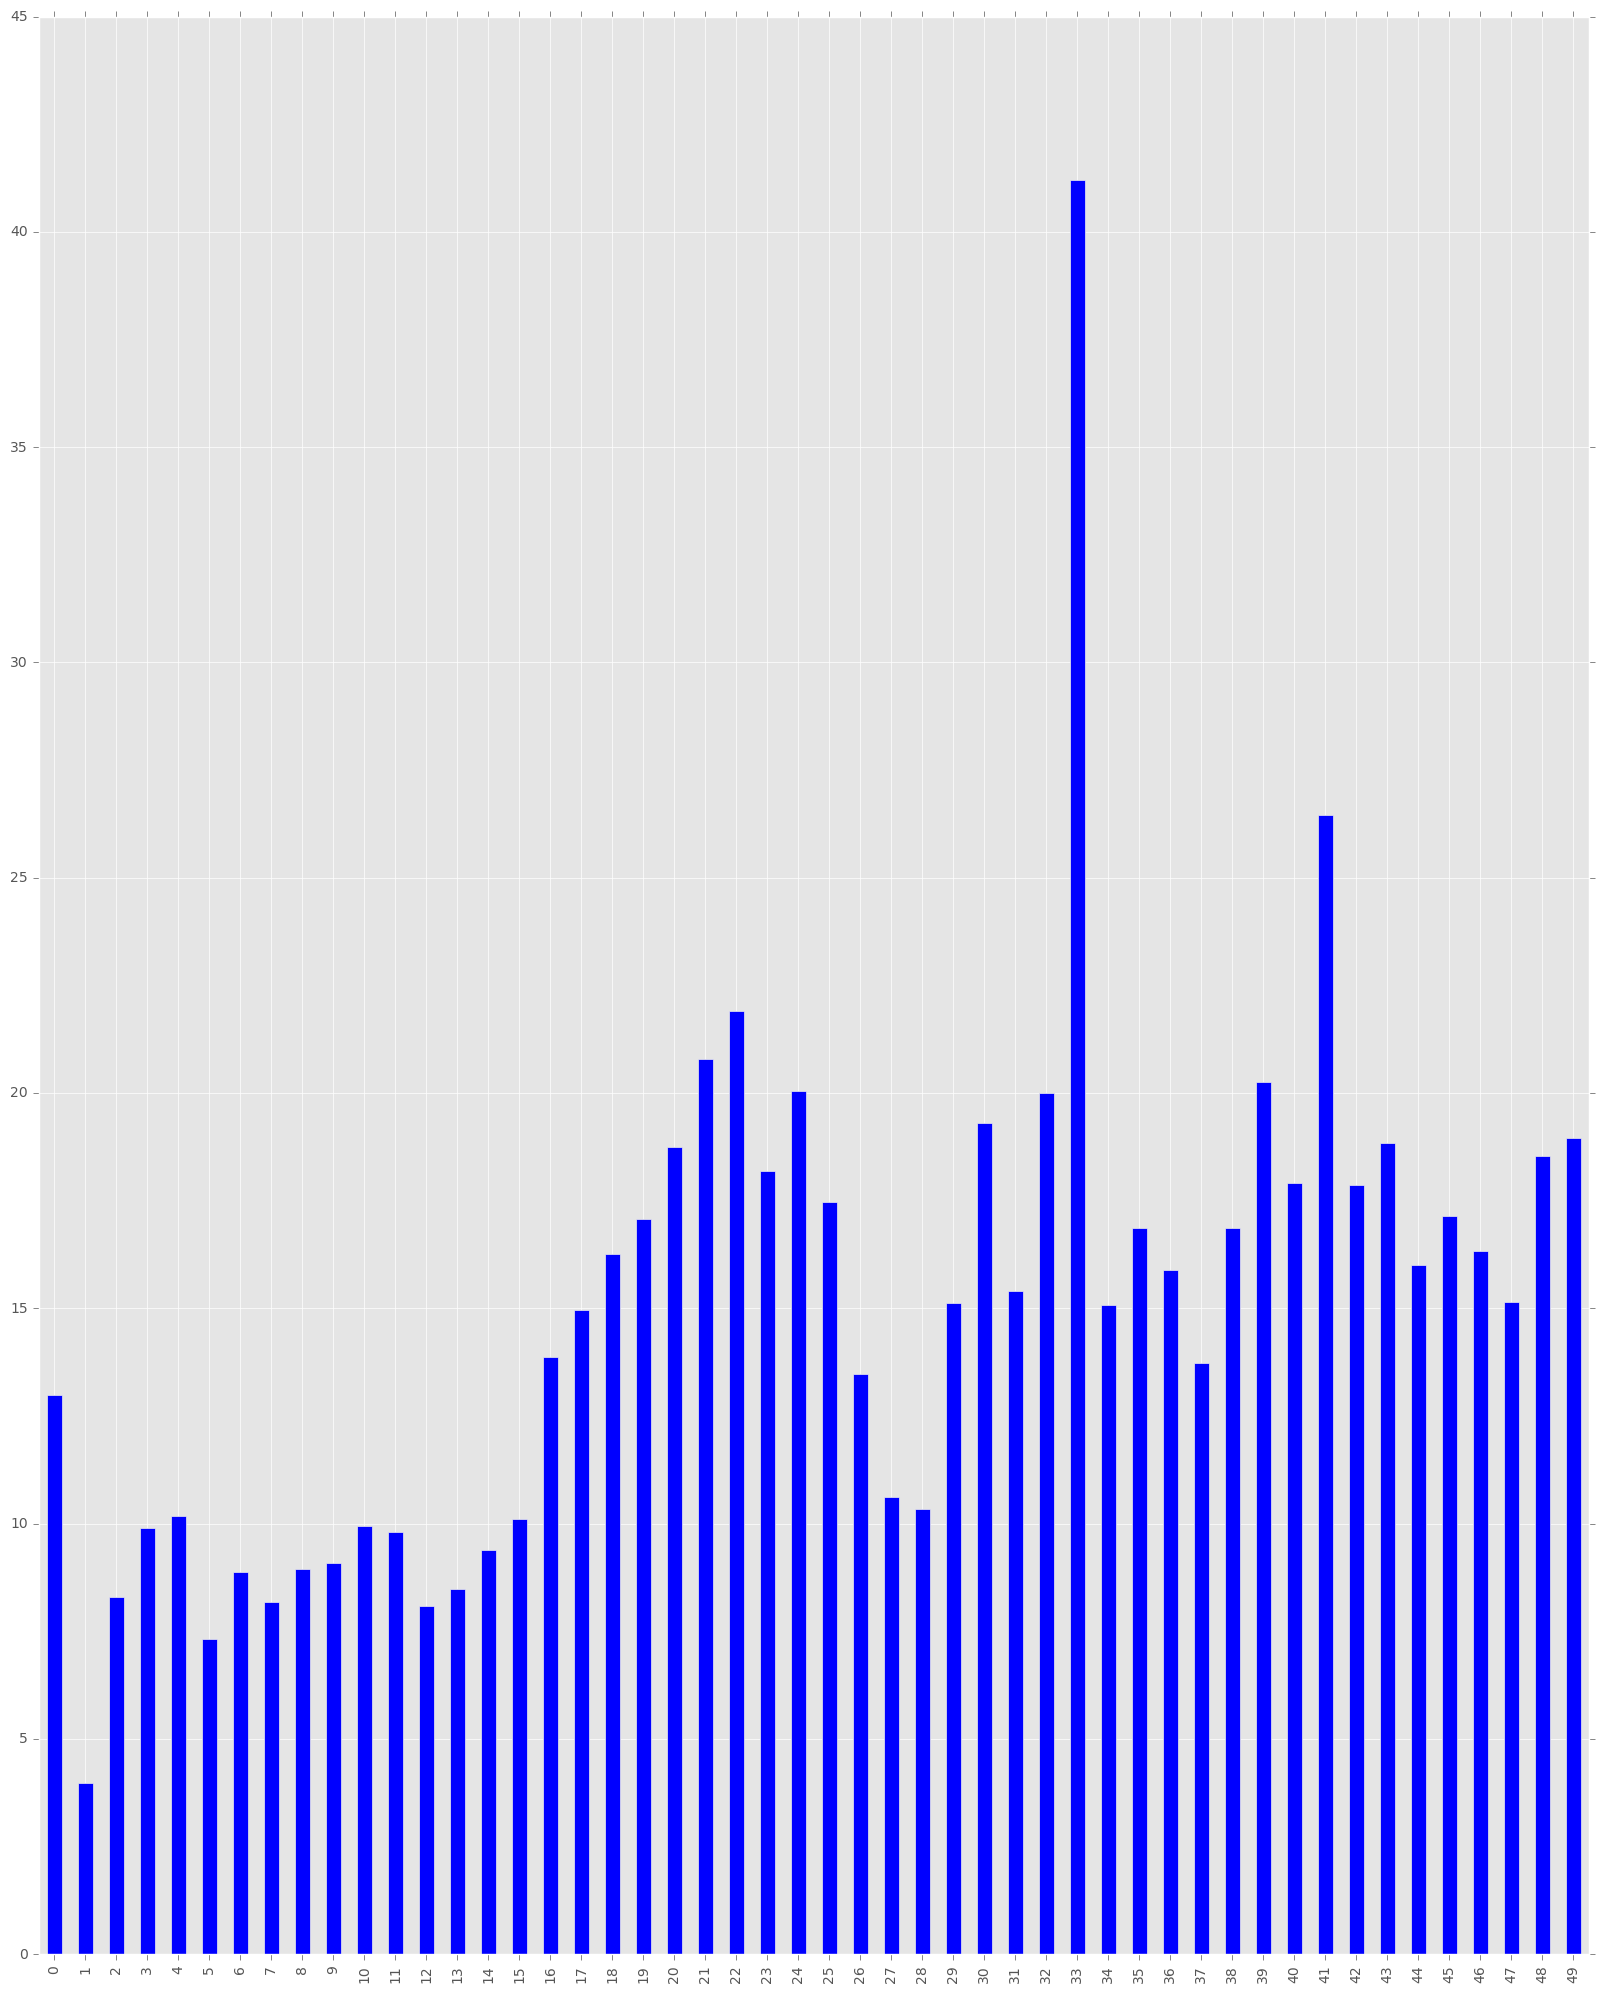

In [21]:
plt.figure(figsize=(20, 25))
result.AvgPositive.plot.bar(color='b')
plt.show()

In [22]:
result['NegativeCount'] = result.NegativeCount * (-1)

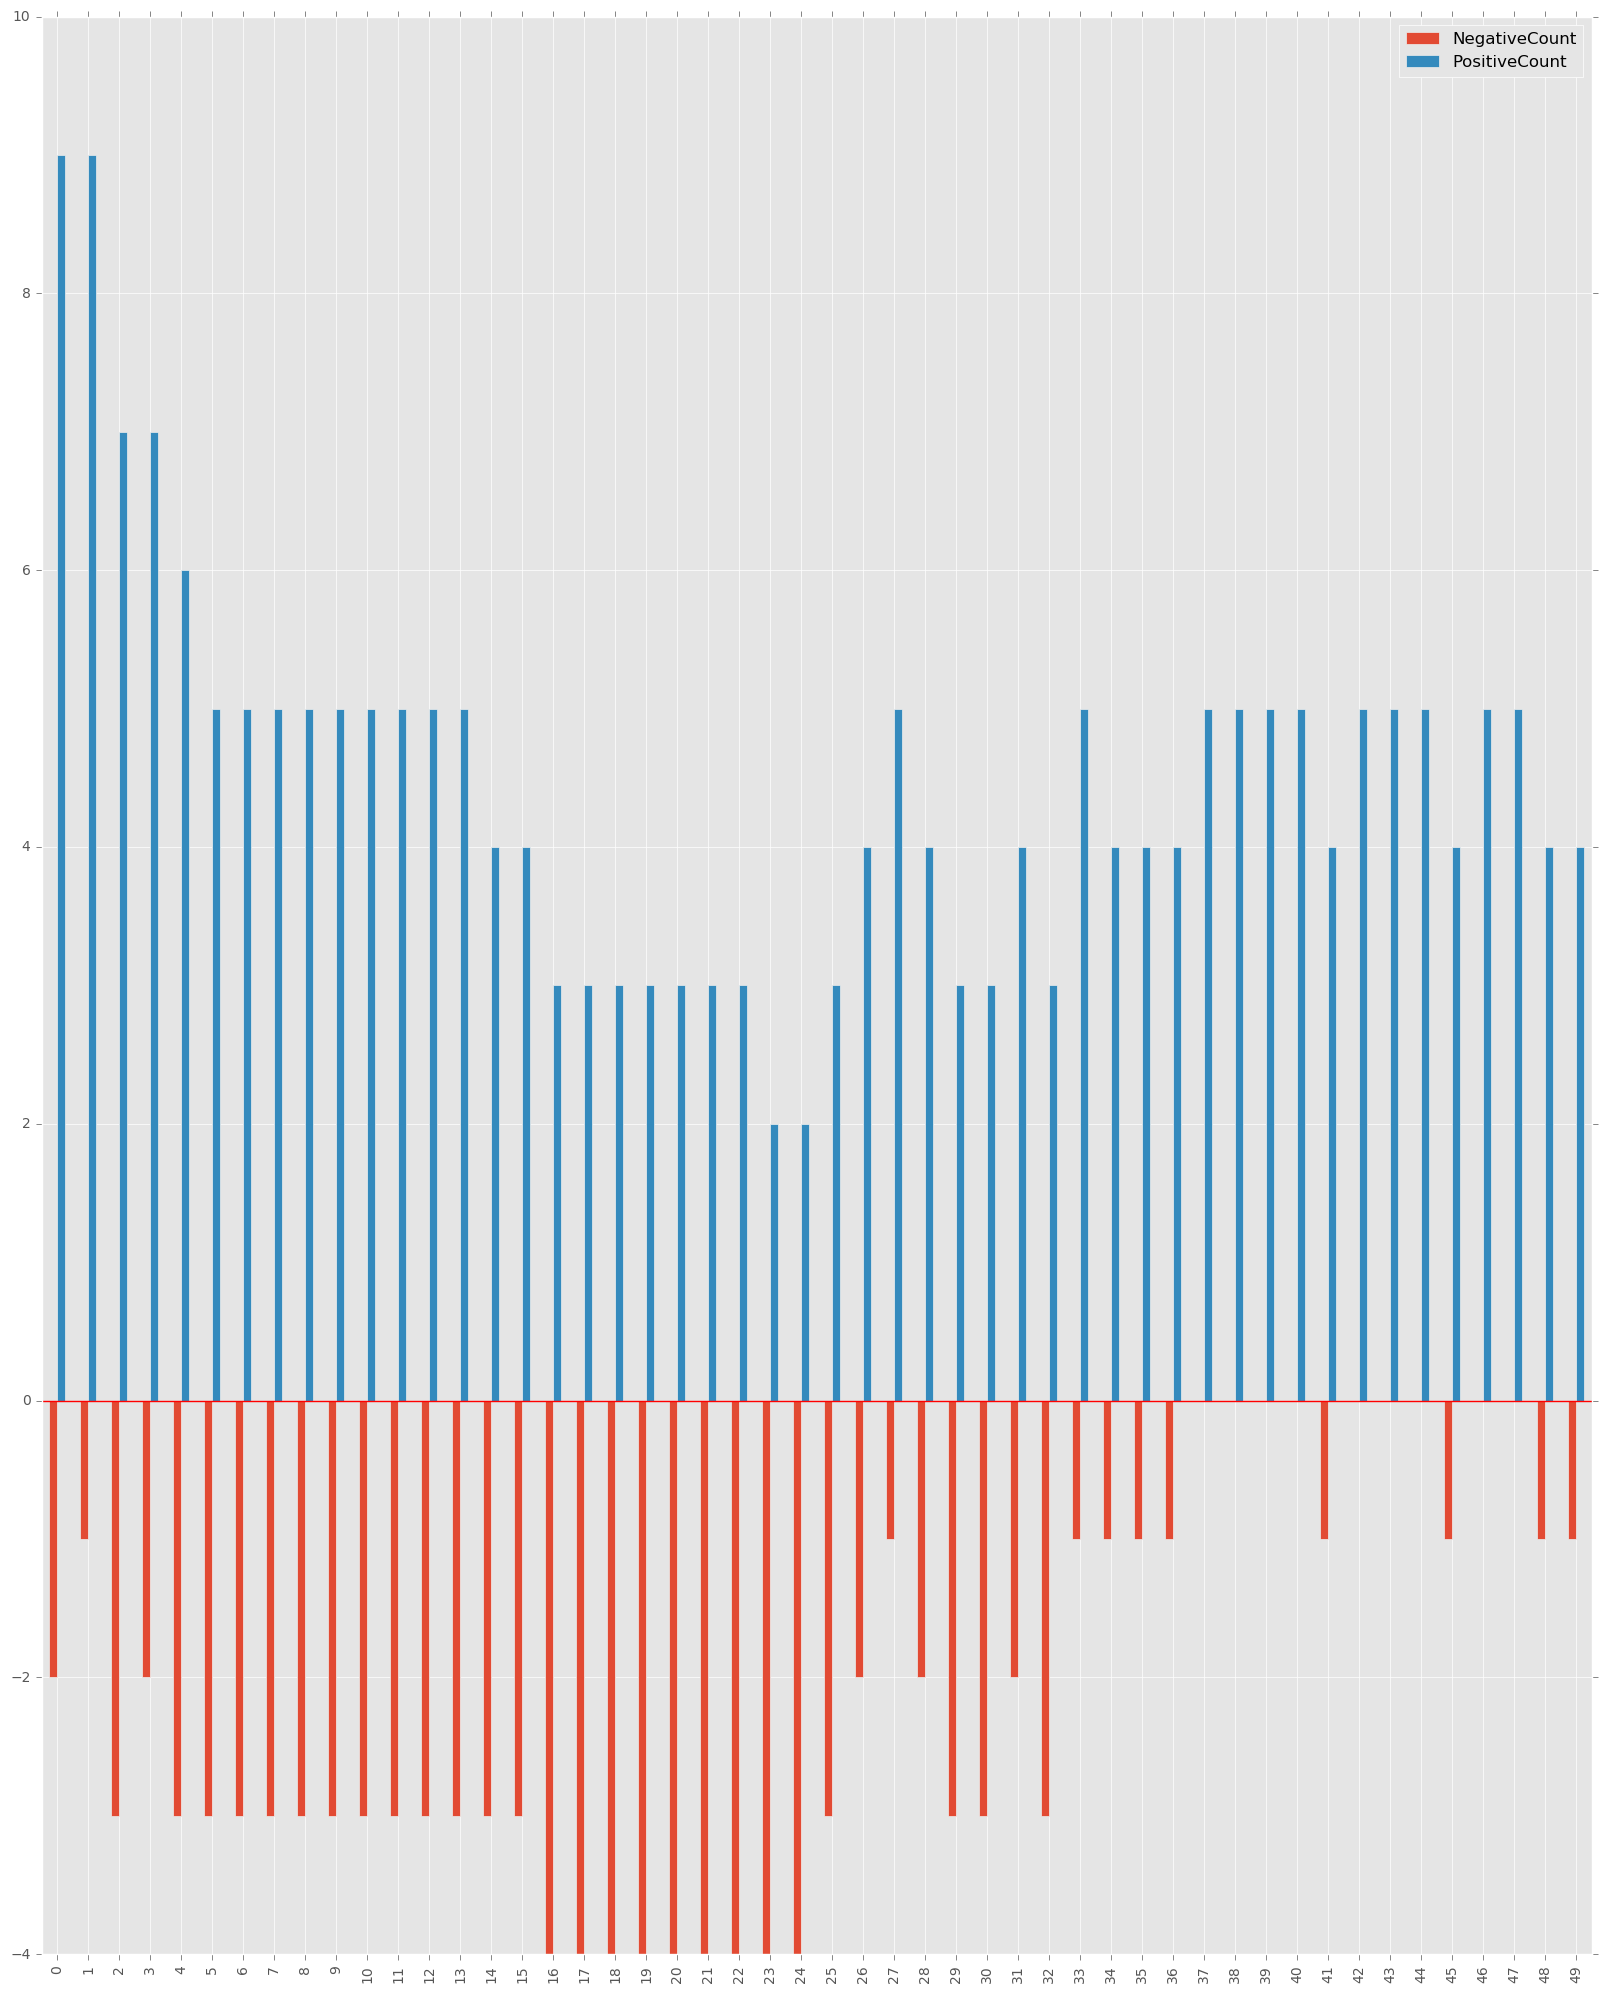

In [23]:
fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(111)
result[['NegativeCount', 'PositiveCount']].plot.bar(ax=ax)
plt.axhline(0, color='r')
plt.show()